# Create feature matrix

## 1. Task list

Next actions:
- Z-norm - preprocessing data
    - 0-1 timescale for length
- Findsignal to gait cycle detection/segmentation
- feature extraction

Waiting:
- load all subjects except HC01
- check HC01 and HC02 dataset - accelerometer values

Maybe list:
- ? fill NA for empty values
- DictVectorizer - LabelEncoder and OneHot
- Standardize or Normalize?
- ML Pipeline
- PCA?

## 2. Import packages and paths

In [2]:
# Importing the Libraries
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle
from itertools import product
from scipy.stats import skew, kurtosis, pearsonr, iqr, zscore
from scipy.signal import butter, welch, filtfilt, resample
import time
import re
import copy
# import nolds
from sklearn import preprocessing
import scipy.io # test matlab code

# from PreprocessFunctions import * # functions for unstacked df with raw data
# from PreprocessFcns import *

%matplotlib inline

Need to run numpy package version numpy: 1.15.1
- version 1.15.4 throws AttributeError
- C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
- b = a[a_slice]

In [3]:
print(np.__version__)

1.15.1


In [4]:
if platform.system() == 'Windows':
    if platform.release() == '10':
        path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\controls'
        folder_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data'
        dict_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
        features_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\FeatureMatrix'

## 3. Feature list

In [ ]:
colnames=['RMSX', 'RMSY', 'RMSZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX',
       'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ',
       'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ',
       'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq',
       'Pdom_rel', 'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 'jerk_mean',
       'jerk_std', 'jerk_skew', 'jerk_kur', 'Sen_X', 'Sen_Y', 'Sen_Z']

In [ ]:
features_list = ['RMSX','RMSY','RMSZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ',
                    'skewX','skewY','skewZ','kurtX','kurtY','kurtZ','xcor_peakXY','xcorr_peakXZ','xcorr_peakYZ',
                    'xcorr_lagXY','xcorr_lagXZ','xcorr_lagYZ','Dom_freq','Pdom_rel','PSD_mean','PSD_std','PSD_skew',
                    'PSD_kur','jerk_mean','jerk_std','jerk_skew','jerk_kur','Sen_X','Sen_Y','Sen_Z']
len(features_list)

In [ ]:
# 37 features
len(colnames)
# acc and gyro = 74 features
# medial chest - acc
# 15 other sensors

## 4. Load HC02 dataset

In [240]:
# use context manager to load pickle file
dict_path2 = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
subj = 'HC02'
filename = os.path.join(dict_path2, subj + 'dict.pkl')
with open(filename,'rb') as filename:
    act_dict = pickle.load(filename)

In [595]:
act_dict

{'LYING': {0: {'tibialis_anterior_left': {'accel':                 Accel X (g)  Accel Y (g)  Accel Z (g)
    Timestamp (ms)                                       
    0                 -0.046815    -0.898390     0.468818
    32                -0.051698    -0.899855     0.479561
    64                -0.054139    -0.908156     0.477607
    96                -0.050721    -0.893507     0.478584
    128               -0.058534    -0.900832     0.468330
    160               -0.050233    -0.904250     0.489326
    192               -0.045838    -0.912551     0.477119
    224               -0.048280    -0.902296     0.463935
    256               -0.045350    -0.900832     0.476143
    288               -0.055116    -0.906203     0.466865
    320               -0.047303    -0.898878     0.467842
    352               -0.038514    -0.901320     0.481514
    384               -0.049744    -0.902296     0.485420
    416               -0.052186    -0.903273     0.471748
    448               -0.

## 5. act_dict structure

In [203]:
act_dict.keys()

dict_keys(['LYING', 'SITTING', 'STANDING', 'WALKING', 'STAIRS DOWN', 'STAIRS UP'])

In [204]:
act_dict['LYING'].keys()

dict_keys([0, 1])

In [205]:
act_dict['LYING'][0].keys()

dict_keys(['tibialis_anterior_left', 'gastrocnemius_right', 'sacrum', 'distal_lateral_shank_right', 'tibialis_anterior_right', 'posterior_forearm_right', 'bicep_right', 'rectus_femoris_left', 'biceps_femoris_right', 'posterior_forearm_left', 'biceps_femoris_left', 'gastrocnemius_left', 'bicep_left', 'medial_chest', 'distal_lateral_shank_left', 'rectus_femoris_right'])

In [121]:
locations = ['tibialis_anterior_left', 'gastrocnemius_right', 'sacrum', 'distal_lateral_shank_right', 
             'tibialis_anterior_right', 'posterior_forearm_right', 'bicep_right', 'rectus_femoris_left', 
             'biceps_femoris_right', 'posterior_forearm_left', 'biceps_femoris_left', 'gastrocnemius_left', 
             'bicep_left', 'medial_chest', 'distal_lateral_shank_left', 'rectus_femoris_right']
for location in locations:
    print(act_dict['LYING'][0][location].keys())

dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])
dict_keys(['accel', 'gyro', 'elec'])


# Testing

## Test matlab vs python features

### Step 1: Create testclip

In [4]:
testclip = act_dict['WALKING'][0]['sacrum']['accel']
testclip.columns=['Accel_X', 'Accel_Y', 'Accel_Z']

In [12]:
testclip.head(3)

,Accel_X,Accel_Y,Accel_Z
Timestamp (ms),,,
1510606486688,0.010315,0.925002,0.245182
1510606486720,-0.009461,0.990311,0.212833
1510606486752,0.023865,1.028641,0.190494


In [13]:
# save testclip as csv
testfile = r'C:\Users\lu-RT&O\Documents\GitHub\testclip.csv'
testclip.to_csv(testfile)

### Step 2: Create matclip from testclip to use Matlab feature extraction

In [9]:
matclip = testclip.reset_index(drop=True)

In [10]:
matclip.head(3)

,Accel_X,Accel_Y,Accel_Z
0,0.010315,0.925002,0.245182
1,-0.009461,0.990311,0.212833
2,0.023865,1.028641,0.190494


In [11]:
# transpose columns as rows
matclipT=matclip.T
matclipT

,0,1,2,3,4,5,6,7,8,9,...,409,410,411,412,413,414,415,416,417,418
Accel_X,0.010315,-0.009461,0.023865,0.015198,-0.083314,-0.169131,-0.067323,0.137514,0.048890,-0.126162,...,0.018006,-0.100160,-0.252262,0.009461,0.197574,-0.047669,-0.215030,-0.142397,-0.075257,-0.070008
Accel_Y,0.925002,0.990311,1.028641,0.983719,0.886671,0.942824,1.047440,1.080888,1.224323,1.232136,...,1.340047,1.286213,1.052201,0.887037,0.953201,1.105913,1.032181,0.820630,0.748730,0.831006
Accel_Z,0.245182,0.212833,0.190494,0.186587,0.190005,0.200137,0.211734,0.223331,0.244083,0.310002,...,0.236759,0.433295,0.499092,0.463569,0.442695,0.392279,0.297185,0.264958,0.264225,0.255680


In [12]:
# save as csv
testfile = r'C:\Users\lu-RT&O\Documents\GitHub\testclipT.csv'
matclipT.to_csv(testfile)

In [13]:
# Savemat
testfile = r'C:\Users\lu-RT&O\Documents\GitHub\testclipinmatlab'
# with open(testfile,'wb') as f:
scipy.io.savemat(testfile, matclip, oned_as='column')

Matlab code to combine test code and check features - getfeatures requires a 3xN array
[feature, label] = getfeatures(testclipT)
label = label' # transpose

#Creates 2x131 cell
matrix=vertcat(label,num2cell(feature)) # need to convert feature double array to cell array
#csvwrite('matlabfeatures.txt',matrix)

#Create 2x131 table with labels and features using Matlab code
x = array2table(matrix(2,:),'VariableNames',matrix(1,:))

#Take 2x131 cell called matrix
#write labels as header
fid = fopen('matlabfeatures.csv', 'w') ;
fprintf(fid, '%s,', x{1,1:end-1}) ;
fprintf(fid, '%s\n', x{1,end}) ;
fclose(fid) ;
#append numeric features then write to csv file
dlmwrite('matlabfeatures.csv', x(2:end,:), '-append') 

### Step 3: Load files to compare matlab vs python features
- load pythonfea in Step 5 first

In [11]:
# load csv file to check Matlab features
mfeatfile = r'C:\Users\lu-RT&O\Documents\GitHub/matlabfeatures.csv'
matlab = pd.read_csv(mfeatfile)

In [14]:
# change and reorder matlab columns
pythonfea = featuretest(testclip)

# colsm = matlab.columns.tolist() # check matlab column order
cols = pythonfea.columns.tolist()
# print(cols, '\n', colsm)

# change cross product column names since abs ones were duplicated
matlab.rename(index=str, columns={'abs CrossProd xy':'abs CrossProd norm xy',
                                  'abs CrossProd xz':'abs CrossProd norm xz',
                                  'abs CrossProd yz':'abs CrossProd norm yz',
                                  'abs CrossProd xy.1':'abs CrossProd xy',
                                  'abs CrossProd xz.1':'abs CrossProd xz',
                                  'abs CrossProd yz.1':'abs CrossProd yz'},
              inplace=True)

# reordered column list for matlab features
colsm = ['x-mean', 'y-mean', 'z-mean', 
         'x-range', 'y-range', 'z-range', 
         'x-IQR', 'y-IQR', 'z-IQR', 
         'x-std', 'y-std', 'z-std', 
         'x-skew', 'y-skew', 'z-skew', 
         'x-kurt', 'y-kurt', 'z-kurt', 
         'x-hist-2', 'x-hist-1', 'x-hist0', 'x-hist1',   
         'y-hist-2', 'y-hist-1', 'y-hist0', 'y-hist1', 
         'z-hist-2', 'z-hist-1', 'z-hist0', 'z-hist1', 
         'x-mean diff', 'y-mean diff', 'z-mean diff', 
         'x-std diff', 'y-std diff', 'z-std diff', 
         'x-skew diff', 'y-skew diff', 'z-skew diff', 
         'x-kurt diff', 'y-kurt diff', 'z-kurt diff', 
         'mean of squares', 
         'std_sum', 
         'corr coeff xy', 'corr coeff xz', 'corr coeff yz', 
         'CrossProd xy', 'CrossProd xz', 'CrossProd yz', 
         'CrossProd norm xy', 'CrossProd norm xz', 'CrossProd norm yz',
         'abs CrossProd xy', 'abs CrossProd xz', 'abs CrossProd yz', 
         'abs CrossProd norm xy', 'abs CrossProd norm xz', 'abs CrossProd norm yz', 
         'x-mean (PSD)', 'y-mean (PSD)', 'z-mean (PSD)', 
         'x-std (PSD)', 'y-std (PSD)', 'z-std (PSD)', 
         'x-skew (PSD)', 'y-skew (PSD)', 'z-skew (PSD)', 
         'x-kurt (PSD)', 'y-kurt (PSD)', 'z-kurt (PSD)', 
         'x_bin_5.000000e-01', 'x_bin_1', 'x_bin_1.500000e+00', 'x_bin_2', 
         'x_bin_2.500000e+00', 'x_bin_3', 'x_bin_3.500000e+00', 'x_bin_4', 
         'x_bin_4.500000e+00', 'x_bin_5', 'x_bin_5.500000e+00', 'x_bin_6', 
         'x_bin_6.500000e+00', 'x_bin_7', 'x_bin_7.500000e+00', 'x_bin_8', 
         'x_bin_8.500000e+00', 'x_bin_9', 'x_bin_9.500000e+00', 'x_bin_10', 
         'y_bin_5.000000e-01', 'y_bin_1', 'y_bin_1.500000e+00', 'y_bin_2', 
         'y_bin_2.500000e+00', 'y_bin_3', 'y_bin_3.500000e+00', 'y_bin_4', 
         'y_bin_4.500000e+00', 'y_bin_5', 'y_bin_5.500000e+00', 'y_bin_6', 
         'y_bin_6.500000e+00', 'y_bin_7', 'y_bin_7.500000e+00', 'y_bin_8', 
         'y_bin_8.500000e+00', 'y_bin_9', 'y_bin_9.500000e+00', 'y_bin_10', 
         'z_bin_5.000000e-01', 'z_bin_1', 'z_bin_1.500000e+00', 'z_bin_2', 
         'z_bin_2.500000e+00', 'z_bin_3', 'z_bin_3.500000e+00', 'z_bin_4', 
         'z_bin_4.500000e+00', 'z_bin_5', 'z_bin_5.500000e+00', 'z_bin_6', 
         'z_bin_6.500000e+00', 'z_bin_7', 'z_bin_7.500000e+00', 'z_bin_8', 
         'z_bin_8.500000e+00', 'z_bin_9', 'z_bin_9.500000e+00', 'z_bin_10']

# reorder matlab feature columns
matlab = matlab[colsm]

In [15]:
# check contents
matlab

,x-mean,y-mean,z-mean,x-range,y-range,z-range,x-IQR,y-IQR,z-IQR,x-std,...,z_bin_5.500000e+00,z_bin_6,z_bin_6.500000e+00,z_bin_7,z_bin_7.500000e+00,z_bin_8,z_bin_8.500000e+00,z_bin_9,z_bin_9.500000e+00,z_bin_10
0,-0.028107,0.98163,0.28277,0.71717,0.94179,0.74696,0.15531,0.27298,0.21491,0.11811,...,0.000886,0.002759,0.000117,0.000169,0.000288,0.000677,0.000164,0.000195,0.000103,0.000026


### Step 4: Load testclip for python features

In [7]:
testfile = r'C:\Users\lu-RT&O\Documents\GitHub\testclip.csv'
testclip = pd.read_csv(testfile)
testclip = testclip.drop('Timestamp (ms)', 1)

In [9]:
testclip.shape

(419, 3)

In [10]:
testclip.head(3)

,Accel_X,Accel_Y,Accel_Z
0,0.010315,0.925002,0.245182
1,-0.009461,0.990311,0.212833
2,0.023865,1.028641,0.190494


### Step 5: Test features - matlab vs python using testclip

### Step 6. View feature sets side by side

#### Reload featuretest() starting here

In [120]:
# with timestep
testfile = r'C:\Users\lu-RT&O\Documents\GitHub\testclip.csv'
testclip = pd.read_csv(testfile, index_col=0)
# without timestamp
# testclip = pd.read_csv(testfile)
# testclip = testclip.drop('Timestamp (ms)', 1)

In [121]:
testclip.head(3)

,Accel_X,Accel_Y,Accel_Z
Timestamp (ms),,,
1510606486688,0.010315,0.925002,0.245182
1510606486720,-0.009461,0.990311,0.212833
1510606486752,0.023865,1.028641,0.190494


In [146]:
# extract features with featuretest and compared to matlab features
pythonfea = featuretest(testclip)
# cleanup type
pythonfea2 = pythonfea.astype('float64')
pythonfea2 = pythonfea2.apply(np.format_float_positional, precision=6)
pythonfea2 = pythonfea2.to_frame()

In [147]:
# view 2 dataframes side by side: Matlab vs Python
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
display_side_by_side(matlab.T,pythonfea2)

,0
x-mean,-0.028107
y-mean,0.981630
z-mean,0.282770
x-range,0.717170
y-range,0.941790
z-range,0.746960
x-IQR,0.155310
y-IQR,0.272980
z-IQR,0.214910
x-std,0.118110


### Step 7. Calculate error in feature sets

In [148]:
# calculate % error for python vs matlab features

# transpose matlab to match pythonfea2
matlabT = matlab.T
# create same index of feature names
matlabT.index = pythonfea2.index
# combine python and matlab features in 1 dataframe
result = pd.concat([pythonfea2, matlabT], axis=1, sort=False)
# rename columns - python matlab percenterror
result.columns = ['python','matlab']
# change from str to float type
result.python = result.python.astype('float64')
# add percent error column
result['percenterror'] = (result['python'] - result['matlab'])*100/result['matlab']
# add absolute error column
result['abs_error'] = abs(result['python'] - result['matlab'])
# cleanup index
result.reset_index(inplace=True)
result = result.rename(columns={'index':'feature'})

In [497]:
result[30:50]

,feature,python,matlab,percenterror,abs_error
30,mean_derivative_x,-0.000192,-0.000192,-8.326395e-02,1.600000e-07
31,mean_derivative_y,-0.000225,-0.000225,5.781118e-02,1.300000e-07
32,mean_derivative_z,0.000025,0.000025,-4.578937e-01,1.150000e-07
33,std_derivative_x,0.131300,0.131460,-1.217100e-01,1.600000e-04
34,std_derivative_y,0.189824,0.190050,-1.189161e-01,2.260000e-04
35,std_derivative_z,0.097145,0.097261,-1.192667e-01,1.160000e-04
36,skew_derivative_x,-0.188444,-0.188440,2.122692e-03,4.000000e-06
37,skew_derivative_y,-0.223380,-0.223380,-1.242527e-14,2.775558e-17
38,skew_derivative_z,1.192307,1.192300,5.871006e-04,7.000000e-06
39,kurt_derivative_x,4.614380,4.614400,-4.334258e-04,2.000000e-05


### Step 8. Test individual features

#### 8.1 Test sum_stddev feature

In [47]:
result.loc[result.feature == 'sum_stddev']

,feature,python,matlab,percenterror,abs_error
43,sum_stddev,0.46835,0.46835,0.0,0.0


In [48]:
print(result.loc[result.feature == 'stddev_X'])
print(result.loc[result.feature == 'stddev_Y'])
print(result.loc[result.feature == 'stddev_Z'])

    feature    python   matlab  percenterror  abs_error
9  stddev_X  0.118108  0.11811     -0.001693   0.000002
     feature    python   matlab  percenterror  abs_error
10  stddev_Y  0.201473  0.20147      0.001489   0.000003
     feature    python   matlab  percenterror  abs_error
11  stddev_Z  0.148769  0.14877     -0.000672   0.000001


In [49]:
result.loc[9]+result.loc[10]+result.loc[11]

feature         stddev_Xstddev_Ystddev_Z
python                           0.46835
matlab                           0.46835
percenterror                 -0.00087646
abs_error                          6e-06
dtype: object

#### 8.2 Test derivative or difference

In [84]:
result[30:42]

,feature,python,matlab,percenterror,abs_error
30,mean_derivative_x,-0.000192,-0.000192,-8.326395e-02,1.600000e-07
31,mean_derivative_y,-0.000225,-0.000225,5.781118e-02,1.300000e-07
32,mean_derivative_z,0.000025,0.000025,-4.578937e-01,1.150000e-07
33,std_derivative_x,0.131300,0.131460,-1.217100e-01,1.600000e-04
34,std_derivative_y,0.189824,0.190050,-1.189161e-01,2.260000e-04
35,std_derivative_z,0.097145,0.097261,-1.192667e-01,1.160000e-04
36,skew_derivative_x,-0.188444,-0.188440,2.122692e-03,4.000000e-06
37,skew_derivative_y,-0.223380,-0.223380,-1.242527e-14,2.775558e-17
38,skew_derivative_z,1.192307,1.192300,5.871006e-04,7.000000e-06
39,kurt_derivative_x,4.614380,4.614400,-4.334258e-04,2.000000e-05


#### 8.3 Test mean squared norm (or mean of squares in matlab)

In [85]:
result[42:43]

,feature,python,matlab,percenterror,abs_error
42,mean_squared_norm,0.373615,0.37361,0.001338,0.000005


#### 8.4 Test correlation coefficients
- Used np.corrcoef instead of np.correlate

In [87]:
# before changes
result[44:47]

,feature,python,matlab,percenterror,abs_error
44,xcorr_XY,-11.497544,0.006345,-181297.799946,11.503889
45,xcorr_XZ,-4.190390,0.036849,-11471.787565,4.227239
46,xcorr_YZ,116.768120,-0.117110,-99808.069337,116.885230


In [111]:
# xcorr_XY
np.corrcoef(testclip.iloc[:,0],testclip.iloc[:,1])[0][1]

0.006345321541608315

In [134]:
# xcorr_XZ
np.corrcoef(testclip.iloc[:,0],testclip.iloc[:,2])[0][1]

-0.11711381488734753

In [114]:
# xcorr_YZ
np.corrcoef(testclip.iloc[:,1],testclip.iloc[:,2])[0][1]

0.03684870063379716

In [148]:
# after changes
result[44:47]

,feature,python,matlab,percenterror,abs_error
44,xcorr_XY,0.006345,0.006345,-0.004728,3.000000e-07
45,xcorr_XZ,-0.117114,-0.117110,0.003416,4.000000e-06
46,xcorr_YZ,0.036849,0.036849,0.000000,0.000000e+00


#### 8.5 Test norm, cross products of norm

In [324]:
tempnorm = np.ones((len(testclip.columns),1))*np.array(np.sqrt(np.sum(np.square(testclip),axis=1)))

In [343]:
finalnorm = testclip/tempnorm.T

In [344]:
finalnorm.head(3)

,Accel_X,Accel_Y,Accel_Z
0,0.010779,0.966564,0.256198
1,-0.009339,0.977633,0.210108
2,0.022807,0.983025,0.182046


In [345]:
# crossprod_norm_xy, should be -0.024382
np.nanmean(finalnormT.iloc[:,0]*finalnormT.iloc[:,1])

-0.024382217543411144

In [356]:
# check changes
print(result[50:53], result[56:59])

              feature    python    matlab  percenterror     abs_error
50  crossprod_norm_xy -0.024382 -0.024382     -0.000000  0.000000e+00
51  crossprod_norm_xz -0.008711 -0.008711     -0.004592  4.000000e-07
52  crossprod_norm_yz  0.251377  0.251380     -0.001193  3.000000e-06                   feature    python    matlab  percenterror     abs_error
56  abs_crossprod_norm_xy  0.024382  0.024382      0.000000  0.000000e+00
57  abs_crossprod_norm_xz  0.008711  0.008711     -0.004592  4.000000e-07
58  abs_crossprod_norm_yz  0.251377  0.251380     -0.001193  3.000000e-06


#### 8.6 Histogram of z-scores

In [401]:
testclip-np.mean(testclip)/np.std(testclip.iloc[:,0], ddof=1)
histtest = testclip-np.mean(testclip)/np.std(testclip,ddof=1)
np.histogram(histtest.iloc[:,0],bins=4, range=(-2,2))

(array([  0,  19, 400,   0], dtype=int64), array([-2., -1.,  0.,  1.,  2.]))

In [409]:
result[18:30]

,feature,python,matlab,percenterror,abs_error
18,hist1_X,0.0,0.0,NaN,0.0
19,hist2_X,19.0,19.0,0.0,0.0
20,hist3_X,400.0,400.0,0.0,0.0
21,hist4_X,0.0,0.0,NaN,0.0
22,hist1_Y,0.0,0.0,NaN,0.0
23,hist2_Y,0.0,0.0,NaN,0.0
24,hist3_Y,0.0,0.0,NaN,0.0
25,hist4_Y,0.0,0.0,NaN,0.0
26,hist1_Z,419.0,419.0,0.0,0.0
27,hist2_Z,0.0,0.0,NaN,0.0


#### 8.7 Test PSD
- frequency matches
- amplitude similar
- adjusted original parameters to fit Matlab features

- Note: Matlab code uses High Pass filter first, then Welch for PSD and binning

In [ ]:
# matlab code
%% Frequency Domain Processing (High Pass + Power Spectra)
filtered = cell(3,1);
PSD_welch = cell(3,1);
f_welch = cell(3,1);
fc = 0.2; %cutoff frequency (Hz)
fs = 30;
f_nyq = fs/2;

%High Pass Filter
for ii = 1:3
    [b, a] = butter(2,(fc*pi)/f_nyq,'high');
    filtered{ii} = filter(b,a,S(ii,:)); 
end

%Power Spectra
for ii = 1:3
    win_size = ceil(length(filtered{ii})/2);
    [PSD_welch{ii}, f_welch{ii}] = pwelch(filtered{ii}, win_size, [], [], fs);
end

%% Features for Each Axis (Frequency Domain)
for ii = 1:3

    %Mean 
    fvec = [fvec nanmean(PSD_welch{ii})]; flab = [flab; [axes{ii} '-mean (PSD)']];

In [233]:
# check PSD features
result[59:71]

,feature,python,matlab,percenterror,abs_error
59,PSD_mean_X,0.001309,0.001023,27.919476,0.000286
60,PSD_mean_Y,0.004213,0.002769,52.148790,0.001444
61,PSD_mean_Z,0.004213,0.001678,151.012869,0.002535
62,PSD_std_X,0.002657,0.002488,6.814070,0.000169
63,PSD_std_Y,0.012979,0.009817,32.216167,0.003162
64,PSD_std_Z,0.012979,0.008670,49.694936,0.004309
65,PSD_skew_X,4.201396,4.822400,-12.877488,0.621004
66,PSD_skew_Y,4.741735,5.532100,-14.286889,0.790365
67,PSD_skew_Z,4.741735,8.018800,-40.867274,3.277065
68,PSD_kur_X,20.541471,30.106000,-31.769511,9.564529


##### check butter() param: N in HPfilter

In [172]:
butter(2,0.75/(0.5*32),btype='highpass',analog=False)

(array([ 0.90109585, -1.80219171,  0.90109585]),
 array([ 1.        , -1.79238564,  0.81199778]))

In [160]:
#Matlab butter in HP filter
# fs = 30, but I used 32 (use 30 for comparison?)
butter(2,(0.2*math.pi)/(30/2),btype='highpass',analog=False)

(array([ 0.9111386 , -1.82227721,  0.9111386 ]),
 array([ 1.        , -1.81436521,  0.83018921]))

Matlab output for x axis
params: array, win_size = 210, noverlap, f=some vector, fs=sample rate
[PSD_welch, f_welch] = pwelch(s(1,:), 210, [], [], 30)

f_welch =
         0
    0.1172
    0.2344
    0.3516
    0.4688

PSD_welch =
    0.0020
    0.0008
    0.0002
    0.0001
    0.0001

Python equivalent
- f_welch 0.       ,  0.1171875,  0.234375 ,  0.3515625,  0.46875  ,
- PSD 3.25891926e-06, 6.70944383e-04, 4.60312756e-04, 5.17537671e-05,
        3.41573502e-05, 1.52932578e-04, 2.64206412e-04, 1.66773013e-03,
        8.03962435e-03, 1.96434924e-03, 7.59507165e-05, 3.73367614
Number of points to overlap between segmene-05,
        2.62080686e-04, 2.14793365e-04, 1.47234345e-04, 5.42776542e-04,
        1.78089195e-03, 1.77307600e-03, 4.21337862e-04, 7.62464287e-05,
        1.84090034e-04, 9.25590985e-05, 6.66485661e-04, 1.03408781e-03,
        
        1.25603781e-06, 3.62593255e-05, 2.40640066e-04, 9.56517874e-05,
        1.55290534e-05, 5.33191601e-05, 4.12289961e-04, 1.28142207e-03,
        9.70177433e-03, 2.88202699e-03, 5.21970648e-05, 3.95020222e-05,

In [212]:
welch(rawclip.iloc[:,0],fs=32,nperseg=min(256,len(rawclip.iloc[:,0])),detrend=False)

(array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
         1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,
         2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,  2.875,
         3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,  3.75 ,  3.875,
         4.   ,  4.125,  4.25 ,  4.375,  4.5  ,  4.625,  4.75 ,  4.875,
         5.   ,  5.125,  5.25 ,  5.375,  5.5  ,  5.625,  5.75 ,  5.875,
         6.   ,  6.125,  6.25 ,  6.375,  6.5  ,  6.625,  6.75 ,  6.875,
         7.   ,  7.125,  7.25 ,  7.375,  7.5  ,  7.625,  7.75 ,  7.875,
         8.   ,  8.125,  8.25 ,  8.375,  8.5  ,  8.625,  8.75 ,  8.875,
         9.   ,  9.125,  9.25 ,  9.375,  9.5  ,  9.625,  9.75 ,  9.875,
        10.   , 10.125, 10.25 , 10.375, 10.5  , 10.625, 10.75 , 10.875,
        11.   , 11.125, 11.25 , 11.375, 11.5  , 11.625, 11.75 , 11.875,
        12.   , 12.125, 12.25 , 12.375, 12.5  , 12.625, 12.75 , 12.875,
        13.   , 13.125, 13.25 , 13.375, 13.5  , 13.625, 13.75 , 

In [184]:
# clip with timestamp index
rawclip = act_dict['WALKING'][0]['sacrum']['accel']

In [417]:
testfs = np.mean(1/(np.diff(rawclip.iloc[:,0].index)/1000))
print(testfs)

31.238672611280265


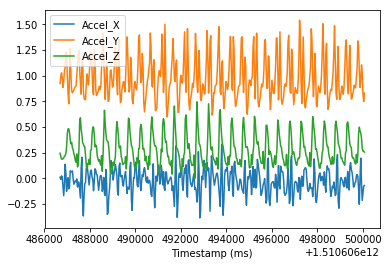

In [185]:
# plot raw data
rawclip.plot()

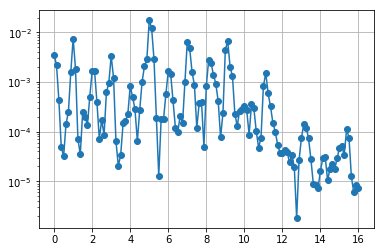

In [211]:
# plot scipy welch - x axis
f, p = welch(rawclip.iloc[:,0],fs=32,nperseg=min(256,len(rawclip.iloc[:,0])),detrend=False)
plt.semilogy(f, p, '-o')
plt.grid()
plt.show()
# added detrend=False, 

Plot PSD on each axis separately to compare to Matlab plots.

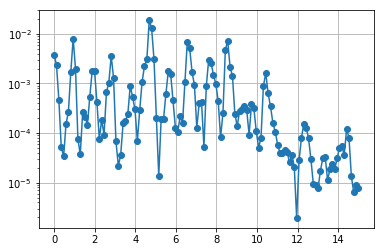

In [477]:
# plot scipy welch - x axis
f, p = welch(rawclip.iloc[:,0],fs=30,nperseg=256,detrend=False)
plt.semilogy(f, p, '-o')
plt.grid()
plt.show()
# added detrend=False, 

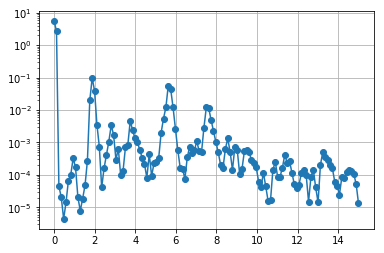

In [488]:
# plot scipy welch - y axis
f, p = welch(rawclip.iloc[:,1],fs=30,nperseg=256,detrend=False)
plt.semilogy(f, p, '-o')
plt.grid()
plt.show()

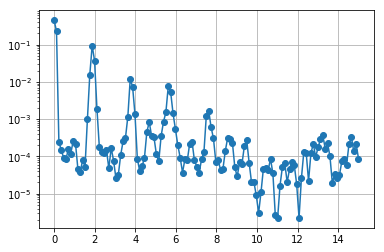

In [489]:
# plot scipy welch - z axis
f, p = welch(rawclip.iloc[:,2],fs=30,nperseg=256,detrend=False)
plt.semilogy(f, p, '-o')
plt.grid()
plt.show()

In [ ]:
# +3 to kurtosis ???

#### 8.8 Test PSD bins
- rerun next 3 code chunks to check PSD binning features

In [225]:
# extract features with featuretest and compared to matlab features
pythonfea = featuretest(testclip)
# cleanup type
pythonfea2 = pythonfea.astype('float64')
pythonfea2 = pythonfea2.apply(np.format_float_positional, precision=6)
pythonfea2 = pythonfea2.to_frame()

In [226]:
# view 2 dataframes side by side: Matlab vs Python
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
display_side_by_side(matlab.T,pythonfea2)

,0
x-mean,-0.028107
y-mean,0.981630
z-mean,0.282770
x-range,0.717170
y-range,0.941790
z-range,0.746960
x-IQR,0.155310
y-IQR,0.272980
z-IQR,0.214910
x-std,0.118110


In [227]:
# calculate % error for python vs matlab features

# transpose matlab to match pythonfea2
matlabT = matlab.T
# create same index of feature names
matlabT.index = pythonfea2.index
# combine python and matlab features in 1 dataframe
result = pd.concat([pythonfea2, matlabT], axis=1, sort=False)
# rename columns - python matlab percenterror
result.columns = ['python','matlab']
# change from str to float type
result.python = result.python.astype('float64')
# add percent error column
result['percenterror'] = (result['python'] - result['matlab'])*100/result['matlab']
# add absolute error column
result['abs_error'] = abs(result['python'] - result['matlab'])
# cleanup index
result.reset_index(inplace=True)
result = result.rename(columns={'index':'feature'})

In [153]:
# test HighPass then binning
result[71:].head(10)

,feature,python,matlab,percenterror,abs_error
71,meanpower_bin1_x,0.000000,0.000022,-100.000000,0.000022
72,meanpower_bin2_x,0.001980,0.002476,-20.038769,0.000496
73,meanpower_bin3_x,0.000486,0.000754,-35.546331,0.000268
74,meanpower_bin4_x,0.000891,0.000955,-6.732823,0.000064
75,meanpower_bin5_x,0.000194,0.000412,-52.946883,0.000218
76,meanpower_bin6_x,0.001641,0.001164,41.015726,0.000477
77,meanpower_bin7_x,0.000071,0.000138,-48.528346,0.000067
78,meanpower_bin8_x,0.000430,0.000378,13.801773,0.000052
79,meanpower_bin9_x,0.000922,0.002287,-59.678125,0.001365
80,meanpower_bin10_x,0.009473,0.008926,6.130543,0.000547


In [167]:
# HP + binning
# adjust power_spectra_welch_axis welch() butter param N=2 (vs 4)
result[71:].head(10)

,feature,python,matlab,percenterror,abs_error
71,meanpower_bin1_x,0.000001,0.000022,-95.366938,0.000021
72,meanpower_bin2_x,0.001375,0.002476,-44.471367,0.001101
73,meanpower_bin3_x,0.000351,0.000754,-53.450128,0.000403
74,meanpower_bin4_x,0.000855,0.000955,-10.501193,0.000100
75,meanpower_bin5_x,0.000189,0.000412,-54.159593,0.000223
76,meanpower_bin6_x,0.001628,0.001164,39.898599,0.000464
77,meanpower_bin7_x,0.000071,0.000138,-48.528346,0.000067
78,meanpower_bin8_x,0.000429,0.000378,13.537118,0.000051
79,meanpower_bin9_x,0.000921,0.002287,-59.721858,0.001366
80,meanpower_bin10_x,0.009466,0.008926,6.052119,0.000540


In [228]:
# HP + binning
# adjust power_spectra_welch_axis welch() butter param N=2 (vs 4)
# adjust power_spectra_welch_axis welch nperseg to min
# adjust power_spectra_welch_axis welch, + detrend=False
# kept welch param fs=32 (Matlab used fs=30)
result[71:].head(10)

,feature,python,matlab,percenterror,abs_error
71,meanpower_bin1_x,0.000001,0.000022,-95.366938,0.000021
72,meanpower_bin2_x,0.001320,0.002476,-46.692513,0.001156
73,meanpower_bin3_x,0.000338,0.000754,-55.174197,0.000416
74,meanpower_bin4_x,0.000615,0.000955,-35.623665,0.000340
75,meanpower_bin5_x,0.000571,0.000412,38.491390,0.000159
76,meanpower_bin6_x,0.001277,0.001164,9.736186,0.000113
77,meanpower_bin7_x,0.000338,0.000138,145.034073,0.000200
78,meanpower_bin8_x,0.000351,0.000378,-7.105994,0.000027
79,meanpower_bin9_x,0.000287,0.002287,-87.448614,0.002000
80,meanpower_bin10_x,0.006042,0.008926,-32.308589,0.002884


### Step 9. Save result dataframe with testclip

In [ ]:
# check result of python vs matlab features
result

In [231]:
# save as csv
testfile = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data analysis\Analysis_ActivityRecognition\matlabpython_features.csv'
result.to_csv(testfile)

# Functions

In [5]:
def power_spectra_welch_axis(rawdata,fm,fM):
    """Compute PSD on each axis then combine into a dataframe"""
    x = rawdata.iloc[:,0]
    y = rawdata.iloc[:,1]
    z = rawdata.iloc[:,2]
    # number of samples in clip
    n = len(x)
    # sampling rate in clip
    Fs = np.mean(1/(np.diff(x.index)/1000))
    
    # adjusted params to match frequency using scipy.welch with matlab.pwelch
#     fx,Pxx_denX = welch(x,fs=30,nperseg=256,detrend=False)
#     fy,Pxx_denY = welch(y,fs=30,nperseg=256,detrend=False)
#     fz,Pxx_denZ = welch(z,fs=30,nperseg=256,detrend=False)
    # added param: detrend=False
    fx,Pxx_denX = welch(x,Fs,nperseg=min(256,n),detrend=False)
    fy,Pxx_denY = welch(y,Fs,nperseg=min(256,n),detrend=False)
    fz,Pxx_denZ = welch(z,Fs,nperseg=min(256,n),detrend=False)
    
    #return PSD in desired interval of freq
    inds = (fx<=fM)&(fx>=fm)
    f=fx[inds]
    Pxx_denX=Pxx_denX[inds]
    Pxx_denY=Pxx_denY[inds]
    Pxx_denZ=Pxx_denZ[inds]
    Pxx_den = {'PSD_X':Pxx_denX,'PSD_Y':Pxx_denY,'PSD_Z':Pxx_denY}
    Pxxdf = pd.DataFrame(data=Pxx_den,index=f)

    return Pxxdf

def featuretest(rawdata):
    """
    Extract features from a simple clip of a single trial and sensor
    Input: simple clip without trial or sensor dict keys
    Output: feature matrix from all clips from given subject and scores for each clip
    Column names separate for acc and gyro data.
    """
    
    features_list = ['meanX','meanY','meanZ','rangeX','rangeY','rangeZ','iqrX','iqrY','iqrZ',
                     'stddev_X','stddev_Y','stddev_Z','skewX','skewY','skewZ','kurtX','kurtY','kurtZ',
                     'hist1_X','hist2_X','hist3_X','hist4_X',
                     'hist1_Y','hist2_Y','hist3_Y','hist4_Y',
                     'hist1_Z','hist2_Z','hist3_Z','hist4_Z',
                     #Moments of derivative: mean, SD, skew, kurtosis
                     'mean_derivative_x','mean_derivative_y','mean_derivative_z',
                     'std_derivative_x','std_derivative_y','std_derivative_z',
                     'skew_derivative_x','skew_derivative_y','skew_derivative_z',
                     'kurt_derivative_x','kurt_derivative_y','kurt_derivative_z',
                     'mean_squared_norm','sum_stddev',
                     'xcorr_XY','xcorr_XZ','xcorr_YZ',
                     'crossprod_raw_xy','crossprod_raw_xz','crossprod_raw_yz',
                     'crossprod_norm_xy','crossprod_norm_xz','crossprod_norm_yz',
                     'abs_crossprod_raw_xy','abs_crossprod_raw_xz','abs_crossprod_raw_yz',
                     'abs_crossprod_norm_xy','abs_crossprod_norm_xz','abs_crossprod_norm_yz',
                     'PSD_mean_X','PSD_mean_Y','PSD_mean_Z',
                     'PSD_std_X','PSD_std_Y','PSD_std_Z',
                     'PSD_skew_X','PSD_skew_Y','PSD_skew_Z',
                     'PSD_kur_X','PSD_kur_Y','PSD_kur_Z',
                     # mean power 20 bins
                     # x axis
                     'meanpower_bin1_x','meanpower_bin2_x','meanpower_bin3_x','meanpower_bin4_x',
                     'meanpower_bin5_x','meanpower_bin6_x','meanpower_bin7_x','meanpower_bin8_x',
                     'meanpower_bin9_x','meanpower_bin10_x','meanpower_bin11_x','meanpower_bin12_x',
                     'meanpower_bin13_x','meanpower_bin14_x','meanpower_bin15_x','meanpower_bin16_x',
                     'meanpower_bin17_x','meanpower_bin18_x','meanpower_bin19_x','meanpower_bin20_x',
                     # y axis
                     'meanpower_bin1_y','meanpower_bin2_y','meanpower_bin3_y','meanpower_bin4_y',
                     'meanpower_bin5_y','meanpower_bin6_y','meanpower_bin7_y','meanpower_bin8_y',
                     'meanpower_bin9_y','meanpower_bin10_y','meanpower_bin11_y','meanpower_bin12_y',
                     'meanpower_bin13_y','meanpower_bin14_y','meanpower_bin15_y','meanpower_bin16_y',
                     'meanpower_bin17_y','meanpower_bin18_y','meanpower_bin19_y','meanpower_bin20_y',
                     # z axis
                     'meanpower_bin1_z','meanpower_bin2_z','meanpower_bin3_z','meanpower_bin4_z',
                     'meanpower_bin5_z','meanpower_bin6_z','meanpower_bin7_z','meanpower_bin8_z',
                     'meanpower_bin9_z','meanpower_bin10_z','meanpower_bin11_z','meanpower_bin12_z',
                     'meanpower_bin13_z','meanpower_bin14_z','meanpower_bin15_z','meanpower_bin16_z',
                     'meanpower_bin17_z','meanpower_bin18_z','meanpower_bin19_z','meanpower_bin20_z',]


    #cycle through all clips for current trial and save dataframe of features for current trial and sensor
    features = []

#     rawdata = clip_data

    #range on each axis
    min_xyz = np.min(rawdata,axis=0)
    max_xyz = np.max(rawdata,axis=0)
    r = np.asarray(max_xyz-min_xyz)

    #Moments on each axis - mean, std dev, skew, kurtosis
    mean = np.asarray(np.mean(rawdata,axis=0))
    # np.std default ddof=0 as default so changed to 1 to match matlab
    std = np.asarray(np.std(rawdata,axis=0, ddof=1))
    sk = skew(rawdata)
    # kurtosis has difference of +3 with matlab feature, thus the offset
    kurt = kurtosis(rawdata)+3

    #Cross-correlation between axes pairs
    xcorr_xy = np.corrcoef(rawdata.iloc[:,0],rawdata.iloc[:,1])[0][1]
    xcorr_xz = np.corrcoef(rawdata.iloc[:,0],rawdata.iloc[:,2])[0][1]
    xcorr_yz = np.corrcoef(rawdata.iloc[:,1],rawdata.iloc[:,2])[0][1]
    xcorr = np.array([xcorr_xy, xcorr_xz, xcorr_yz])

    # interquartile range
    iqrange = iqr(rawdata,axis=0)
    
    # histogram of z-score values
    hist = rawdata-np.mean(rawdata)/np.std(rawdata,ddof=1)
    hist_z_scores_x = np.histogram(hist.iloc[:,0],bins=4, range=(-2,2))
    hist_z_scores_y = np.histogram(hist.iloc[:,1], bins=4, range=(-2,2))
    hist_z_scores_z = np.histogram(hist.iloc[:,2], bins=4, range=(-2,2))
    
    hist_z_scores = np.concatenate((hist_z_scores_x[0], hist_z_scores_y[0], hist_z_scores_z[0]), axis=None)

    # derivative - for 3 axis
    derivative = np.diff(rawdata, axis=0)
    # mean of derivative
    mean_derivative = np.mean(derivative,axis=0)
    # std dev of derivative
    std_derivative = np.std(derivative,axis=0)
    # skewness of derivative
    skew_derivative = skew(derivative,axis=0)
    # kurtosis of derivative
        # added offset +3
    kurt_derivative = kurtosis(derivative,axis=0)+3
    moments_of_derivative = np.concatenate((mean_derivative,std_derivative,skew_derivative,kurt_derivative), axis=None)

    # sum of xyz std dev
    sum_stddev = np.array([np.sum(std)])

    # mean of the squared norm
    mean_squared_norm = np.array([np.mean(np.mean(np.square(rawdata)))])

    # normalize values (divided by acc norm) to get cross products
    # The norm should sum across xyz axis at each instance of time
    normdenominator = np.ones((len(rawdata.columns),1))*np.array(np.sqrt(np.sum(np.square(rawdata),axis=1)))
    norm = rawdata/normdenominator.T
    
    # cross products with raw and norm data
    crossprod_norm_xy = np.nanmean(norm.iloc[:,0]*norm.iloc[:,1])
    crossprod_norm_xz = np.nanmean(norm.iloc[:,0]*norm.iloc[:,2])
    crossprod_norm_yz = np.nanmean(norm.iloc[:,1]*norm.iloc[:,2])
    abs_crossprod_norm_xy = np.abs(crossprod_norm_xy)
    abs_crossprod_norm_xz = np.abs(crossprod_norm_xz)
    abs_crossprod_norm_yz = np.abs(crossprod_norm_yz)
    crossprod_raw_xy = np.nanmean(rawdata.iloc[:,0]*rawdata.iloc[:,1])
    crossprod_raw_xz = np.nanmean(rawdata.iloc[:,0]*rawdata.iloc[:,2])
    crossprod_raw_yz = np.nanmean(rawdata.iloc[:,1]*rawdata.iloc[:,2])
    abs_crossprod_raw_xy = np.abs(crossprod_raw_xy)
    abs_crossprod_raw_xz = np.abs(crossprod_raw_xz)
    abs_crossprod_raw_yz = np.abs(crossprod_raw_yz)
    
    crossprod = np.array([crossprod_raw_xy, crossprod_raw_xz, crossprod_raw_yz,
                          crossprod_norm_xy, crossprod_norm_xz, crossprod_norm_yz,
                          abs_crossprod_raw_xy, abs_crossprod_raw_xz, abs_crossprod_raw_yz,
                          abs_crossprod_norm_xy, abs_crossprod_norm_xz, abs_crossprod_norm_yz])
    
    # High pass filter before passing to PSD (to compare with Matlab process)
    rawdata = HPfilter_testclip(rawdata)
    
    # power spectral density (PSD)
# changed fm=0, to fm=1 like Andrew's code
    Pxx = power_spectra_welch_axis(rawdata,fm=0,fM=10)
    #moments of PSD
    Pxx_moments = np.array([np.nanmean(Pxx.iloc[:,0].values),np.nanmean(Pxx.iloc[:,1].values),np.nanmean(Pxx.iloc[:,2].values),
            np.nanstd(Pxx.iloc[:,0].values),np.nanstd(Pxx.iloc[:,1].values),np.nanstd(Pxx.iloc[:,2].values),
            skew(Pxx.iloc[:,0].values),skew(Pxx.iloc[:,1].values),skew(Pxx.iloc[:,2].values),
            kurtosis(Pxx.iloc[:,0].values),kurtosis(Pxx.iloc[:,1].values),kurtosis(Pxx.iloc[:,2].values)])
########################
    
    # Mean power in 0.5 Hz bins between 0 and 10 Hz (x, y, z)
    binedges = np.arange(0,10.5,0.5)
    powerbin_df = Pxx.groupby(pd.cut(Pxx.index, bins=binedges)).mean().fillna(0)
    
    powerbinarray = np.concatenate((powerbin_df.iloc[:,0],powerbin_df.iloc[:,1],powerbin_df.iloc[:,2]), axis=None)
    
#     # Andrew's mean PSD binning code
#     #power spectra averaged within bins
#     fm = 1; fM = 10; nbins = 10 #frequency bins
# # figure x=Pxx ?
#     Fs = np.mean(1/(np.diff(Pxx.index)/1000)) # sampling rate in clip
#     n = Pxx.size
#     timestep = 1/Fs
#     bin1 = int(timestep*n*fm)
#     bin2 = int(timestep*n*fM)
#     bins = np.linspace(bin1,bin2,nbins,dtype=int) #sample indices
#     deltab = int(0.5*np.diff(bins)[0]) #half the size of bin (in samples)
#     Pxxm = []
#     for i in bins:
#         start = int(max(i-deltab,bins[0]))
#         end = int(min(i+deltab,bins[-1]))
#         Pxxm.append(np.mean(Pxx[start:end]))
#     Pxxm = np.asarray(Pxxm)
# #     plt.plot(bins/(timestep*n),Pxxm)
#     powerbinarray = Pxxm
########################################
    #Assemble features in array
    X = np.concatenate((mean,r,iqrange,std,sk,kurt,hist_z_scores,moments_of_derivative,
                        mean_squared_norm,sum_stddev,xcorr,crossprod,Pxx_moments,powerbinarray))
    
    # old code that worked without .reshape()
#     features.append(X)
#     #feature matrix for all clips from current trial
#     F = np.asarray(X)
# pass data=F in pd.DataFrame below
    features = pd.DataFrame(data=X.reshape((1,131)),columns=features_list,dtype='float32')
    
    return features

## test small example due to Attribute error from numpy 1.15.4 version (1.15.1 works fine)

In [77]:
# test small example due to Attribute error from numpy 1.15.4 version (1.15.1 works fine)
mean = np.asarray([1,2,3])
std = np.asarray([1,1,1])
a = np.concatenate((mean, std))
b = ['meanX','meanY','meanZ','stdX','stdY','stdZ']

In [18]:
# example mean
mean = np.asarray(np.mean(df.rawdata[0],axis=0))
std = np.asarray(np.std(df.rawdata[0],axis=0))
print(mean, std)

[-0.04977925 -0.90175348  0.47448254] [0.0045224  0.0047801  0.00737043]


In [10]:
mean.shape

(3,)

In [19]:
a = np.concatenate((mean, std))
b = ['meanX','meanY','meanZ','stdX','stdY','stdZ']

In [20]:
a

array([-0.04977925, -0.90175348,  0.47448254,  0.0045224 ,  0.0047801 ,
        0.00737043])

In [22]:
a.shape

(6,)

In [21]:
pd.DataFrame(a.reshape((1,6)),columns=b,dtype='float32')

,meanX,meanY,meanZ,stdX,stdY,stdZ
0,-0.049779,-0.901753,0.474483,0.004522,0.00478,0.00737


In [67]:
df.rawdata[0].head(5)

,Accel X (g),Accel Y (g),Accel Z (g)
Timestamp (ms),,,
0,-0.046815,-0.898390,0.468818
32,-0.051698,-0.899855,0.479561
64,-0.054139,-0.908156,0.477607
96,-0.050721,-0.893507,0.478584
128,-0.058534,-0.900832,0.468330


## More functions

In [6]:
# modified to take testclip
def HPfilter_testclip(clip_data,cutoff=0.75,ftype='highpass'):
    """
    Highpass (or lowpass) filter data. HP to remove gravity (offset - limb orientation) from accelerometer 
    data from each visit (trial)
    
    Input: Activity dictionary, cutoff freq [Hz], task, sensor location and type of filter 
    (highpass or lowpass).
    """
    rawdata = clip_data
#     if rawdata.empty is True: #skip if no data for current sensor
#         continue
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    x = rawdata.values
    Fs = np.mean(1/(np.diff(rawdata.index)/1000)) #sampling rate
    #filter design
    cutoff_norm = cutoff/(0.5*Fs)
#     b,a = butter(4,cutoff_norm,btype=ftype,analog=False)
# Matlab: change params to N=2, cutoff_norm= (prev 0.046875, cutoff=0.75)
    b,a = butter(2,cutoff_norm,btype=ftype,analog=False)
    #filter data
    xfilt = filtfilt(b,a,x,axis=0)
    rawdatafilt = pd.DataFrame(data=xfilt,index=rawdata.index,columns=rawdata.columns)
    clip_data = rawdatafilt
    
    return clip_data

# def HPfilter(act_dict,task,loc,cutoff=0.75,ftype='highpass'):
#     """
#     Highpass (or lowpass) filter data. HP to remove gravity (offset - limb orientation) from accelerometer 
#     data from each visit (trial)
    
#     Input: Activity dictionary, cutoff freq [Hz], task, sensor location and type of filter 
#     (highpass or lowpass).
#     """
#     sensor = 'accel'
#     for trial in act_dict[task].keys():
#         rawdata = act_dict[task][trial][loc][sensor]
#         if rawdata.empty is True: #skip if no data for current sensor
#             continue
#         idx = rawdata.index
#         idx = idx-idx[0]
#         rawdata.index = idx
#         x = rawdata.values
#         Fs = np.mean(1/(np.diff(rawdata.index)/1000)) #sampling rate
#         #filter design
#         cutoff_norm = cutoff/(0.5*Fs)
#         b,a = butter(4,cutoff_norm,btype=ftype,analog=False)
#         #filter data
#         xfilt = filtfilt(b,a,x,axis=0)
#         rawdatafilt = pd.DataFrame(data=xfilt,index=rawdata.index,columns=rawdata.columns)
#         act_dict[task][trial][loc][sensor] = rawdatafilt

In [7]:
def unstack_ar_dictionary(act_dict):
    """Takes a 4-level nested dictionary and unstacks into a dataframe."""
    df = pd.DataFrame([(k1, k2, k3, k4, v) for k1, k234v in act_dict.items()
                           for k2, k34v in k234v.items()
                           for k3, k4v in k34v.items()
                           for k4, v in k4v.items()])
    df.columns = ['task','trial','location','sensor','rawdata']
    return df

def extract_date_from_timestamp(timestamp):
    """Convert UNIX to Timestamp data type and cleanup timestamp dataframe
    Input: Dataframe with timestamp annotations in UNIX time in milliseconds
    Output: Dataframe with tasks
    """
    timestamp.reset_index(inplace=True)
    timestamp.insert(1,'date',pd.to_datetime(timestamp['Start Timestamp (ms)'], unit='ms'))
    timestamp.drop(timestamp.columns[[2,3]], inplace=True, axis=1)
    # adjust trial number to start from 0
    timestamp.Trial = timestamp.Trial - 1
    # keep date only in date column
    timestamp.date = timestamp.date.dt.date
    # rename columns
    timestamp.rename(index=str, columns={'Value':'task', 'Trial':'trial'}, inplace=True)
    
    return timestamp

def process_annotations(path):
    """
    Processes raw annotations file to extract start / end timestamps and remove unnecessary data
    Inputs:  path - filepath of the subject folder containing annotations.csv
    Outputs: df - dataframe containing list of activities and their start / end timestamps
    """
    df = pd.read_csv(os.path.join(path, 'annotations.csv'))
    del df['Timestamp (ms)']
    del df['AnnotationId']
    del df['AuthorId']
    
    # subset Activity Recognition data by partially match EventType string
    df = df[df['EventType'].str.match('Activity')]
    del df['EventType']
    df.Value = df.Value.shift(-1)
    df = df.dropna()
    
    # Create Trial column for Value
    sorter = set(df.Value.unique().flatten())
    sorterIndex = dict(zip(sorter, range(len(sorter))))        
    df['Value_Rank'] = df['Value'].map(sorterIndex)
    df['Trial'] = df.groupby('Value')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    del df['Value_Rank']
    df = df.reset_index(drop=True).set_index('Value')
    
    return df

def onesubject_meta_raw(dictionary_path, annotation_path, subj):
    """
    Combines the metadata and rawdata into a dataframe before filtering and feature extraction.
    The selected subject's pickle file containing nested dictionary of raw AR data is loaded.
    The dates from the annotation file are added to the final dataframe's metadata.
    
    Functions called:
    process_annotations()
    extract_date_from_timestamp()
    unstack_ar_dictionary()
    
    Input:
    dictionary_path - path that contains the raw data with metadata in nested dictionary format
    annotation_path - path that holds the annotation timestamps that contains the date metadata
    subj - 4 character string ID for subject
    
    Output: Dataframe with metadata (subject, date, test, task, trial, location, sensor)
        and raw data. This dataframe is ready for filtering and feature extraction.
     
    Example: 
    dictionary_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
    annotation_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\controls'
    subj = 'HC02'
    df = onesubject_meta_raw(dictionary_path, annotation_path, subj)
    """
    # use context manager to reload pickle file
    filename = os.path.join(dictionary_path, subj + 'dict.pkl')
    with open(filename,'rb') as filename:
        act_dict = pickle.load(filename)

    # get timestamp info for feature matrix
    subject_annotation_path = os.path.join(annotation_path, subj)
    timestamp = process_annotations(subject_annotation_path)
    timestamp = extract_date_from_timestamp(timestamp)

    # unstack nested dictionary structure
    df = unstack_ar_dictionary(act_dict)
    # add metadata
    df.insert(0,'subject',subj)
    df.insert(1,'test','activity recognition')
    # merge date data from timestamps
    df = pd.merge(df, timestamp, on=['task','trial'])
    # move date column to 2nd column position
    cols = list(df)
    cols.insert(1, cols.pop(cols.index('date')))
    df = df.loc[:, cols]
    
    return df

def feature_extraction(df, sensor_type='accel'):
    """
    This function takes a dataframe with metadata and raw data from IMUs,
    filters out accelerometer or gyroscope sensor data from specified locations, 
    then extracts 131 features for each trial.
    
    Input: 
    df - Flattened dataframe with task, trial, location, sensor, and IMU raw data
    sensor_type -   'accel' for accelerometer sensor data only
                    'both' for accelerometer and gyroscope sensor data
                    Default is 'accel'.
    
    Output:
    df_feature - Dataframe with metadata, raw data and features
    """
    # filter accelerometer data
    if sensor_type=='accel':
        df_feature = df.loc[df.sensor == sensor_type]
        #########
        df_feature.reset_index(drop=True, inplace=True)
    # else filter accelerometer and gyro data
    elif sensor_type=='both':

        # acc/gyr locations
        locations = ['sacrum', 'distal_lateral_shank_right', 'distal_lateral_shank_left',
                     'posterior_forearm_right', 'posterior_forearm_left']
        # subset 5 locations
        df_feature = df[df.location.isin(locations)]
        df_feature = df_feature.loc[df_feature.sensor != 'elec']
   
    # drop empty dataframes by using len=0 condition
    df_feature = df_feature[df_feature.rawdata.map(lambda d: len(d)) > 0]
    # reset index
    df_feature.reset_index(drop=True, inplace=True)

    features = pd.DataFrame()
    for ind, val in enumerate(df_feature.rawdata):
        trialfeature = featuretest(val)
#         features = features.append(trialfeature, ignore_index=True)
        features = pd.concat([features, trialfeature], axis=0, ignore_index=True)
    # concat features to meta/raw data
    df_feature = pd.concat([df_feature,features], axis=1)#, ignore_index=True)
    
    return df_feature

# Modify data processing pipeline to take final data structure

## Data Structure for feature matrix
- Template: subject.date.test.task.trial.location.sensor.rawdata.features
- Example: HC01.20180101.AR.lying.0.sacrum.accel.rawdata.features

## Step 1: Create table of metadata and raw data 

In [8]:
# test function
dictionary_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
subj = 'HC02'
annotation_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\controls'
df = onesubject_meta_raw(dictionary_path, annotation_path, subj)

In [9]:
# get accelerometer feature matrix from all locations
test1 = feature_extraction(df, 'accel')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

In [10]:
# check for missing data across sensors
test1.groupby('location').count()

,subject,date,test,task,trial,sensor,rawdata,meanX,meanY,meanZ,...,meanpower_bin11_z,meanpower_bin12_z,meanpower_bin13_z,meanpower_bin14_z,meanpower_bin15_z,meanpower_bin16_z,meanpower_bin17_z,meanpower_bin18_z,meanpower_bin19_z,meanpower_bin20_z
location,,,,,,,,,,,,,,,,,,,,,
bicep_left,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
bicep_right,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
biceps_femoris_left,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
biceps_femoris_right,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
distal_lateral_shank_left,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
distal_lateral_shank_right,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
gastrocnemius_left,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
gastrocnemius_right,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
medial_chest,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22


In [11]:
df.loc[df.sensor == 'accel']

,subject,date,test,task,trial,location,sensor,rawdata
0,HC02,2017-11-13,activity recognition,LYING,0,tibialis_anterior_left,accel,Accel X (g) Accel Y (g) Acce...
3,HC02,2017-11-13,activity recognition,LYING,0,gastrocnemius_right,accel,Accel X (g) Accel Y (g) Acce...
6,HC02,2017-11-13,activity recognition,LYING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
9,HC02,2017-11-13,activity recognition,LYING,0,distal_lateral_shank_right,accel,Accel X (g) Accel Y (g) Acce...
12,HC02,2017-11-13,activity recognition,LYING,0,tibialis_anterior_right,accel,Accel X (g) Accel Y (g) Acce...
15,HC02,2017-11-13,activity recognition,LYING,0,posterior_forearm_right,accel,Accel X (g) Accel Y (g) Acce...
18,HC02,2017-11-13,activity recognition,LYING,0,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
21,HC02,2017-11-13,activity recognition,LYING,0,rectus_femoris_left,accel,Accel X (g) Accel Y (g) Acce...
24,HC02,2017-11-13,activity recognition,LYING,0,biceps_femoris_right,accel,Accel X (g) Accel Y (g) Acce...
27,HC02,2017-11-13,activity recognition,LYING,0,posterior_forearm_left,accel,Accel X (g) Accel Y (g) Acce...


# Test unstack and check rawdata for bicep_left
- test case Lying, trial 0, accel

In [759]:
dictionary_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
subj = 'HC02'
filename = os.path.join(dictionary_path, subj + 'dict.pkl')
with open(filename,'rb') as filename:
    act_dict = pickle.load(filename)
testrawdata = unstack_ar_dictionary(act_dict)


In [762]:
testrawdata.loc[testrawdata.sensor == 'accel']

# so not a downstream function issue
# Check extract_data()

,task,trial,location,sensor,rawdata
0,LYING,0,tibialis_anterior_left,accel,Accel X (g) Accel Y (g) Acce...
3,LYING,0,gastrocnemius_right,accel,Accel X (g) Accel Y (g) Acce...
6,LYING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
9,LYING,0,distal_lateral_shank_right,accel,Accel X (g) Accel Y (g) Acce...
12,LYING,0,tibialis_anterior_right,accel,Accel X (g) Accel Y (g) Acce...
15,LYING,0,posterior_forearm_right,accel,Accel X (g) Accel Y (g) Acce...
18,LYING,0,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
21,LYING,0,rectus_femoris_left,accel,Accel X (g) Accel Y (g) Acce...
24,LYING,0,biceps_femoris_right,accel,Accel X (g) Accel Y (g) Acce...
27,LYING,0,posterior_forearm_left,accel,Accel X (g) Accel Y (g) Acce...


# Test HC03 - No accel data missing

In [ ]:
dictionary_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
subj = 'HC03'
filename = os.path.join(dictionary_path, subj + 'dict.pkl')
with open(filename,'rb') as filename:
    act_dict = pickle.load(filename)
testrawdata = unstack_ar_dictionary(act_dict)


In [6]:
testrawdata.loc[testrawdata.sensor == 'accel']

,task,trial,location,sensor,rawdata
0,LYING,0,tibialis_anterior_left,accel,Accel X (g) Accel Y (g) Acce...
3,LYING,0,gastrocnemius_right,accel,Accel X (g) Accel Y (g) Acce...
6,LYING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
9,LYING,0,distal_lateral_shank_right,accel,Accel X (g) Accel Y (g) Acce...
12,LYING,0,tibialis_anterior_right,accel,Accel X (g) Accel Y (g) Acce...
15,LYING,0,posterior_forearm_right,accel,Accel X (g) Accel Y (g) Acce...
18,LYING,0,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
21,LYING,0,rectus_femoris_left,accel,Accel X (g) Accel Y (g) Acce...
24,LYING,0,biceps_femoris_right,accel,Accel X (g) Accel Y (g) Acce...
27,LYING,0,posterior_forearm_left,accel,Accel X (g) Accel Y (g) Acce...


In [7]:
testrawdata.loc[testrawdata.sensor == 'accel'].groupby('location').count()

,task,trial,sensor,rawdata
location,,,,
bicep_left,22,22,22,22
bicep_right,22,22,22,22
biceps_femoris_left,22,22,22,22
biceps_femoris_right,22,22,22,22
distal_lateral_shank_left,22,22,22,22
distal_lateral_shank_right,22,22,22,22
gastrocnemius_left,22,22,22,22
gastrocnemius_right,22,22,22,22
medial_chest,22,22,22,22


# ******************************

In [12]:
# compare to feature_extraction results - SAME result
dictionary_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
subj = 'HC03'
annotation_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\controls'
df03 = onesubject_meta_raw(dictionary_path, annotation_path, subj)
# test03 = feature_extraction(df03, 'accel')
# test03.groupby('location').count()

# ******************************

In [14]:
test03 = feature_extraction(df03, 'accel')
# test03.groupby('location').count()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np

In [15]:
test03

,subject,date,test,task,trial,location,sensor,rawdata,meanX,meanY,...,meanpower_bin11_z,meanpower_bin12_z,meanpower_bin13_z,meanpower_bin14_z,meanpower_bin15_z,meanpower_bin16_z,meanpower_bin17_z,meanpower_bin18_z,meanpower_bin19_z,meanpower_bin20_z
0,HC03,2017-11-16,activity recognition,LYING,0,tibialis_anterior_left,accel,Accel X (g) Accel Y (g) Acce...,-0.020202,-1.003260,...,2.526400e-06,2.268125e-06,1.738883e-06,1.449625e-06,2.178686e-06,1.415501e-06,1.391064e-06,1.466399e-06,2.215662e-06,1.800471e-06
1,HC03,2017-11-16,activity recognition,LYING,0,gastrocnemius_right,accel,Accel X (g) Accel Y (g) Acce...,-0.218182,-0.959553,...,1.383951e-06,1.257965e-06,1.768352e-06,2.015636e-06,1.542907e-06,1.703435e-06,1.443899e-06,1.072083e-06,1.743489e-06,1.587971e-06
2,HC03,2017-11-16,activity recognition,LYING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...,-0.213355,0.204170,...,5.624707e-08,4.496442e-08,3.655530e-08,3.142001e-08,1.983826e-08,2.180930e-08,2.793358e-08,2.639523e-08,1.931273e-08,2.354354e-08
3,HC03,2017-11-16,activity recognition,LYING,0,distal_lateral_shank_right,accel,Accel X (g) Accel Y (g) Acce...,0.133912,0.399586,...,2.014989e-07,1.358058e-07,8.264148e-08,7.299958e-08,4.217725e-08,4.217058e-08,4.083189e-08,3.781605e-08,2.606778e-08,2.165177e-08
4,HC03,2017-11-16,activity recognition,LYING,0,tibialis_anterior_right,accel,Accel X (g) Accel Y (g) Acce...,-0.038292,0.954746,...,1.878279e-06,2.356136e-06,1.778903e-06,2.330267e-06,1.660518e-06,1.779310e-06,1.386939e-06,1.123688e-06,1.917682e-06,1.392786e-06
5,HC03,2017-11-16,activity recognition,LYING,0,posterior_forearm_right,accel,Accel X (g) Accel Y (g) Acce...,0.597431,-0.340216,...,1.275340e-05,1.323240e-05,8.361123e-06,3.807136e-06,2.240338e-06,3.490220e-06,3.863027e-06,4.766455e-06,3.189674e-06,2.733162e-06
6,HC03,2017-11-16,activity recognition,LYING,0,bicep_right,accel,Accel X (g) Accel Y (g) Acce...,-0.131047,-0.015614,...,3.291123e-05,2.724676e-05,2.746129e-05,2.820381e-05,7.070617e-06,9.308261e-06,5.725463e-06,9.415140e-06,4.467285e-06,4.008112e-06
7,HC03,2017-11-16,activity recognition,LYING,0,rectus_femoris_left,accel,Accel X (g) Accel Y (g) Acce...,-0.011396,-0.737641,...,2.441215e-06,2.033433e-06,1.735243e-06,2.628685e-06,2.895945e-06,1.366367e-06,1.117596e-06,1.582535e-06,1.346417e-06,2.267868e-06
8,HC03,2017-11-16,activity recognition,LYING,0,biceps_femoris_right,accel,Accel X (g) Accel Y (g) Acce...,0.033023,-0.082723,...,1.337362e-06,1.326146e-06,1.619415e-06,1.802120e-06,1.414846e-06,1.338752e-06,1.215730e-06,1.203354e-06,1.134971e-06,9.758319e-07
9,HC03,2017-11-16,activity recognition,LYING,0,posterior_forearm_left,accel,Accel X (g) Accel Y (g) Acce...,0.753954,0.288314,...,1.580595e-05,8.473613e-06,9.127015e-06,6.319317e-06,5.677201e-06,2.060176e-06,1.870791e-06,2.244738e-06,2.047840e-06,1.708754e-06


# *******************

## Use HC03 and test Matlab's findsignal()

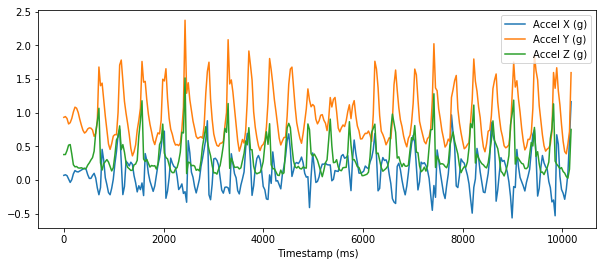

In [16]:
test03.rawdata[290].plot(figsize=(10,4))
plt.legend(loc='upper right')

In [17]:
test03.query('location=="sacrum" & \
                    ( (task=="WALKING") or (task=="STAIRS DOWN") or (task=="STAIRS UP") )&\
                     ((trial==0) or (trial==1)) ')

,subject,date,test,task,trial,location,sensor,rawdata,meanX,meanY,...,meanpower_bin11_z,meanpower_bin12_z,meanpower_bin13_z,meanpower_bin14_z,meanpower_bin15_z,meanpower_bin16_z,meanpower_bin17_z,meanpower_bin18_z,meanpower_bin19_z,meanpower_bin20_z
226,HC03,2017-11-16,activity recognition,WALKING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...,0.102279,0.958999,...,0.000567,0.004167,0.000931,0.000679,0.000435,0.002841,0.001445,0.000727,0.000601,0.001237
242,HC03,2017-11-16,activity recognition,WALKING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...,0.112144,0.950300,...,0.001288,0.000729,0.001184,0.000739,0.000336,0.000418,0.001443,0.005469,0.001254,0.000788
290,HC03,2017-11-16,activity recognition,STAIRS DOWN,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...,0.121876,0.931025,...,0.002597,0.001519,0.001293,0.002742,0.004886,0.001442,0.000785,0.000593,0.001332,0.000600
306,HC03,2017-11-16,activity recognition,STAIRS DOWN,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...,0.137875,0.889294,...,0.004942,0.013419,0.005224,0.003683,0.001552,0.000651,0.004063,0.001533,0.001856,0.000423
322,HC03,2017-11-16,activity recognition,STAIRS UP,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...,0.079665,0.847399,...,0.000420,0.000553,0.000638,0.001253,0.000647,0.000163,0.000033,0.000025,0.000135,0.000183
338,HC03,2017-11-16,activity recognition,STAIRS UP,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...,0.106441,0.833443,...,0.005216,0.016798,0.001051,0.000529,0.000548,0.001955,0.002452,0.007228,0.000705,0.000419


In [18]:
# save few files on Matlab to check findsignal
testfile = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data analysis\Analysis_ActivityRecognition'
test03.rawdata[226].to_csv(os.path.join(testfile, 'test_walking.csv'), index=False)
test03.rawdata[290].to_csv(os.path.join(testfile, 'test_stairsdown.csv'), index=False)
test03.rawdata[322].to_csv(os.path.join(testfile, 'test_stairsup.csv'), index=False)

### Function detect_peaks.py
- http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

In [27]:
# %load ./../functions/detect_peaks.py
"""Detect peaks in data based on their amplitude and other features."""

from __future__ import division, print_function
# import numpy as np

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.5"
__license__ = "MIT"


def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height (if parameter
        `valley` is False) or peaks that are smaller than maximum peak height
         (if parameter `valley` is True).
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=-1.2, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)

    Version history
    ---------------
    '1.0.5':
        The sign of `mph` is inverted if parameter `valley` is True
    
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
        if mph is not None:
            mph = -mph
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
            if mph is not None:
                mph = -mph
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()

### Test detect_peaks

In [52]:
test03.rawdata[290].shape

(319, 3)

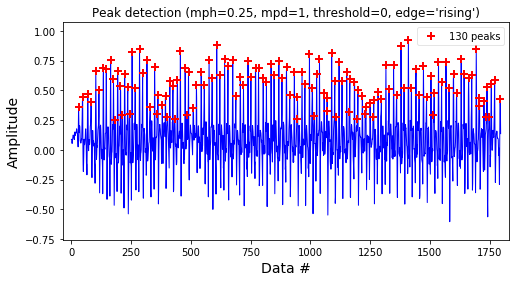

In [44]:
# detect peaks
peaks = detect_peaks(test03.rawdata[226].iloc[:,0], mph= 0.25, show=True)

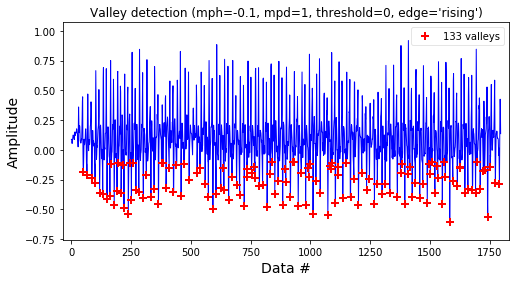

In [49]:
# detect valleys
valleys = detect_peaks(test03.rawdata[226].iloc[:,0], mph= -0.10, valley=True, show=True)

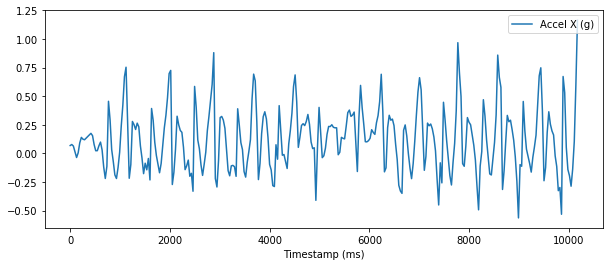

In [32]:
# X axis signal
test03.rawdata[290].iloc[:,0].plot(figsize=(10,4))
plt.legend(loc='upper right')

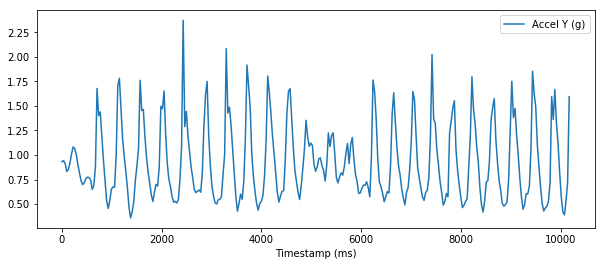

In [50]:
# Y axis signal
test03.rawdata[290].iloc[:,1].plot(figsize=(10,4))
plt.legend(loc='upper right')

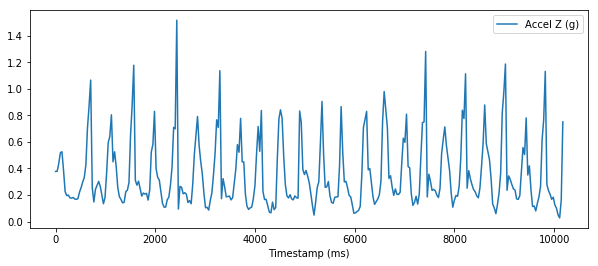

In [51]:
# Z axis signal
test03.rawdata[290].iloc[:,2].plot(figsize=(10,4))
plt.legend(loc='upper right')

### Detect valleys

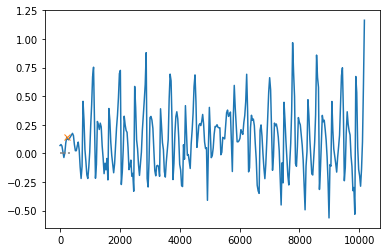

In [32]:
from scipy.signal import find_peaks
x = test03.rawdata[290].iloc[:,0]
peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [7]:
from scipy.signal import find_peaks

In [28]:
test03.rawdata[290].iloc[:,0].values.tolist()

[0.06866559853513365,
 0.07745479514763076,
 0.06402685587853796,
 0.015320057984283153,
 -0.03607232776379021,
 0.004699778744182481,
 0.09185931181811212,
 0.13995574883649994,
 0.12408636606393485,
 0.11908140688181845,
 0.13360799572747428,
 0.14715800717174066,
 0.16156252384222206,
 0.17499046311131486,
 0.15509269855802274,
 0.07696650644693648,
 0.02313267719539169,
 0.02349889372091241,
 0.06622415503166224,
 0.09857328145265852,
 0.029480430304417382,
 -0.11834897383077747,
 -0.21930266269932108,
 -0.11285572594796678,
 0.45514610513466097,
 0.2929121843289844,
 0.03338673990997165,
 -0.07061875333791122,
 -0.18805218585488687,
 -0.21954680704966825,
 -0.12347600518806745,
 0.010315098802166744,
 0.238956282902266,
 0.4225528343633176,
 0.6696269169146261,
 0.753002212558175,
 0.2525062943465324,
 -0.21747158007171752,
 -0.0975967040512704,
 0.2788738841840237,
 0.2511635004196231,
 0.208804455634394,
 0.2642252231631952,
 0.23212024109254606,
 0.06585793850614152,
 -0.040833

In [33]:
from admit.util.peakfinder.PeakDetect import PeakDetect

ModuleNotFoundError: No module named 'admit'

# extract_data()

In [12]:
def extract_data(SubID, path):
    """
    For a given subject, extracts and separates accelerometer, gyroscope, and 
    EMG/ECG data into trials and sensor per activity
    """
    ## This is the annotations.csv dataset cleaned
    ## Used to match timestamp ranges to the accel, gyro, elec data
    timestamps = process_annotations(path)
#    timestamps = fix_errors(SubID, timestamps)
#    timestamps = add_unstruct_data(timestamps)
    
    # Creates list of sensor locations from folders within subject's raw data directory
    locations = [locs for locs in os.listdir(path) if os.path.isdir(os.path.join(path, locs))]
    
    # Creates dictionary of empty dataframes to merge all accelerometer, gyroscope, and EMG/ECG data for each sensor
    accel = {locs: pd.DataFrame() for locs in locations}
    gyro = {locs: pd.DataFrame() for locs in locations}
    elec = {locs: pd.DataFrame() for locs in locations}
    
    # Finds and merges all accelerometer, gyroscope, and EMG/ECG data for each sensor, retains datetime information
    for root, dirs, files in os.walk(path, topdown=True):
        for filenames in files:
            if filenames.endswith('accel.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                accel[location] = accel[location].append(temp_df)

            elif filenames.endswith('gyro.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                gyro[location] = gyro[location].append(temp_df)

            elif filenames.endswith('elec.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                elec[location] = elec[location].append(temp_df)
                
    # List based on Value data of Activity Recognition
    complete= list(['LYING','SITTING','STANDING','WALKING','STAIRS DOWN','STAIRS UP'])
    complete_acts = complete
    
    # Complete dictionary of all activities
    act_dict = {acts: pd.DataFrame() for acts in complete_acts}
    
    # Populate dictionary keys per activity with every iteration / trial
    for activities in complete_acts:
        
        startSize = timestamps.loc[activities, 'Start Timestamp (ms)']
        
        if np.size(startSize) == 1:
            startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)']
            endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)']
        else:
            startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)'].values
            endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)'].values

        # Create trial dictionary with each key containing all sensor data related with each activity's trial
        trial_dict = {trials: pd.DataFrame() for trials in range(0, np.size(startTimestamp))}

        # Populate trial directory keys
        for trials in range(0, np.size(startTimestamp)):

            if np.size(startSize) == 1:
                startTime = startTimestamp
                endTime = endTimestamp
            else:
                startTime = startTimestamp[trials]
                endTime = endTimestamp[trials]

            # Create sensor location dictionary with each key corresponding to sensor locations
            sensor_dict = {locs: pd.DataFrame() for locs in locations}

            # Extract sensor data and populate sensor_dict with sensor data
            for location in locations:

                data = {'accel': pd.DataFrame(), 'gyro': pd.DataFrame(), 'elec': pd.DataFrame()}

                if not accel[location].empty:
                    accelData = accel[location]
                    data['accel'] = accelData[(accelData.index >= startTime) & (accelData.index <= endTime)]  
 
                if not gyro[location].empty:
                    gyroData = gyro[location]
                    data['gyro'] = gyroData[(gyroData.index >= startTime) & (gyroData.index <= endTime)]
                   
                if not elec[location].empty:
                    elecData = elec[location]
                    data['elec'] = elecData[(elecData.index >= startTime) & (elecData.index <= endTime)]
                   
                sensor_dict[location] = data

            trial_dict[trials] = sensor_dict

        act_dict[activities] = trial_dict
    
    return act_dict, timestamps

### Features should look like this

In [254]:
# output of featuretest()
pythonfea

,meanX,meanY,meanZ,rangeX,rangeY,rangeZ,iqrX,iqrY,iqrZ,stddev_X,...,meanpower_bin11_z,meanpower_bin12_z,meanpower_bin13_z,meanpower_bin14_z,meanpower_bin15_z,meanpower_bin16_z,meanpower_bin17_z,meanpower_bin18_z,meanpower_bin19_z,meanpower_bin20_z
0,-0.028107,0.981632,0.282775,0.717174,0.941787,0.74696,0.155093,0.272526,0.214237,0.118108,...,0.00056,0.028699,0.003796,0.000316,0.000646,0.006482,0.002114,0.000556,0.000478,0.000332


### 2.1 Feature extraction - 2 options
1. Acc features for all locations
2. Acc/Gyr features from 5 locations

In [13]:
def feature_extraction(df, sensor_type='accel'):
    """
    This function takes a dataframe with metadata and raw data from IMUs,
    filters out accelerometer or gyroscope sensor data from specified locations, 
    then extracts 131 features for each trial.
    
    Input: 
    df - Flattened dataframe with task, trial, location, sensor, and IMU raw data
    sensor_type -   'accel' for accelerometer sensor data only
                    'both' for accelerometer and gyroscope sensor data
                    Default is 'accel'.
    
    Output:
    df_feature - Dataframe with metadata, raw data and features
    """
    # filter accelerometer data
    if sensor_type=='accel':
        df_feature = df.loc[df.sensor == sensor_type]
    # else filter accelerometer and gyro data
    else:
        # acc/gyr locations
        locations = ['sacrum', 'distal_lateral_shank_right', 'distal_lateral_shank_left',
                     'posterior_forearm_right', 'posterior_forearm_left']
        # subset 5 locations
        df_feature = df[df.location.isin(locations)]
        df_feature = df_feature.loc[df_feature.sensor != 'elec']
        
    # drop empty dataframes by using len=0 condition
    df_feature = df_feature[df_feature.rawdata.map(lambda d: len(d)) > 0]
    # reset index
    df_feature.reset_index(drop=True, inplace=True)

    features = pd.DataFrame()
    for ind, val in enumerate(df_feature.rawdata):
        trialfeature = featuretest(val)
        features = features.append(trialfeature, ignore_index=True)
    # concat features to meta/raw data
    df_feature = pd.concat([df_feature,features], axis=1)#, ignore_index=True)
    
    return df_feature

In [ ]:
# get accelerometer feature matrix from all locations
feature_extraction(df, 'accel')

In [435]:
#########
# adjust filename
########

# save file
# save as csv
testfile = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data analysis\Analysis_ActivityRecognition\testfeaturematrix.csv'
test2.to_csv(testfile, index=False)

In [ ]:
# extracted features: 
df = feature_extraction(df, sensor_type='both')

In [586]:
# check for missing data across sensors
df.groupby('location').count()

,subject,date,test,task,trial,sensor,rawdata,meanX,meanY,meanZ,...,meanpower_bin11_z,meanpower_bin12_z,meanpower_bin13_z,meanpower_bin14_z,meanpower_bin15_z,meanpower_bin16_z,meanpower_bin17_z,meanpower_bin18_z,meanpower_bin19_z,meanpower_bin20_z
location,,,,,,,,,,,,,,,,,,,,,
distal_lateral_shank_left,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
distal_lateral_shank_right,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
posterior_forearm_left,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
posterior_forearm_right,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
sacrum,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44


In [ ]:
# save as csv
testfile = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data analysis\Analysis_ActivityRecognition\testfeaturematrix.csv'
test2.to_csv(testfile, index=False)

### 2.2 Rearrange with different feature labels (acc-, gyr-) as preprocessing before ML pipeline

In [14]:
def rearrange_accgyr_features(df):
    """
    This function takes a dataframe with accelerometer and gyroscope features
    on alternating rows, relabels feature names with prefix acc- or gyr- for
    accelerometer or gyroscope data respectively.
    This prepares the feature matrix for scikit-learn modeling.
    
    Input: 
    df - Dataframe with metadata, raw data, and acc/gyr features on alternating rows.
    
    Output:
    feature_matrix - Dataframe with acc and gyr features relabeled and concatenated horizontally.
    """   
    # try separatig acc and gyr df instead
    acc_df = df.loc[df.sensor == 'accel'].copy()
    gyr_df = df.loc[df.sensor == 'gyro'].copy()
  
    # rename feature columns with prefix to specify acc- or gyr- rawdata and features
    new_names_acc = [(i, 'acc-'+i) for i in acc_df.iloc[:, 7:].columns.values]
    acc_df.rename(columns = dict(new_names_acc), inplace=True)
    new_names_gyr = [(i, 'gyr-'+i) for i in gyr_df.iloc[:, 7:].columns.values]
    gyr_df.rename(columns = dict(new_names_gyr), inplace=True)

    # delete sensor column
    acc_df = acc_df.drop('sensor', 1)
    gyr_df = gyr_df.drop('sensor', 1)
    
    # merge acc and gyr features using task, trial, location as keys
    final_df = pd.merge(acc_df, gyr_df, on=['subject','date','test','task','trial','location'])
    
    # move gyr-rawdata column next to acc-rawdata to keep feature matrix to the right side
    colnames = final_df.columns.tolist()
    neworder = colnames[:7] + colnames[138:139] + colnames[7:138] + colnames[139:]
    final_df = final_df[neworder]
    
    return final_df

In [593]:
feamatrix = rearrange_accgyr_features(df)
feamatrix.head(2)

,subject,date,test,task,trial,location,acc-rawdata,gyr-rawdata,acc-meanX,acc-meanY,...,gyr-meanpower_bin11_z,gyr-meanpower_bin12_z,gyr-meanpower_bin13_z,gyr-meanpower_bin14_z,gyr-meanpower_bin15_z,gyr-meanpower_bin16_z,gyr-meanpower_bin17_z,gyr-meanpower_bin18_z,gyr-meanpower_bin19_z,gyr-meanpower_bin20_z
0,HC02,temp date,activity recognition,LYING,0,sacrum,Accel X (g) Accel Y (g) Acce...,Gyro X (°/s) Gyro Y (°/s) Gy...,-0.058348,0.183076,...,0.000075,0.000077,0.000067,0.000057,0.000055,0.000079,0.000054,0.000062,0.000045,0.000045
1,HC02,temp date,activity recognition,LYING,0,distal_lateral_shank_right,Accel X (g) Accel Y (g) Acce...,Gyro X (°/s) Gyro Y (°/s) Gy...,0.105776,0.906628,...,0.000336,0.000195,0.000197,0.000209,0.000138,0.000108,0.000091,0.000057,0.000047,0.000065


In [594]:
# save file
# save as csv
testfile = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data analysis\Analysis_ActivityRecognition\accgyr_feature_to_pipeline.csv'
feamatrix.to_csv(testfile, index=False)

# ***************

# Check extract_data() raw data and timestamps to find missing trials

In [28]:
# check extract data
SubID = 'HC02'
testpath1 = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\controls'
testpath2 = os.path.join(testpath1, SubID)
testactdict, testtimestamp = extract_data(SubID, testpath2)
testunstacked = unstack_ar_dictionary(testactdict)

# Create dataset for HC03 for Ami to test

In [29]:
SubID = 'HC03'
testpath31 = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\controls'
testpath32 = os.path.join(testpath31, SubID)
testactdict, testtimestamp = extract_data(SubID, testpath32)
testunstacked3 = unstack_ar_dictionary(testactdict)

In [53]:
testunstacked3[(testunstacked3.location=='sacrum') & (testunstacked3.sensor=='accel') & 
              ((testunstacked3.task==('WALKING'))|(testunstacked3.task==('STAIRS DOWN'))|(testunstacked3.task==('STAIRS UP')) &
              ((testunstacked3.trial==0)|(testunstacked3.trial==1)))]
# why does it have trial 2 and 3?

,task,trial,location,sensor,rawdata
711,WALKING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
759,WALKING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...
807,WALKING,2,sacrum,accel,Accel X (g) Accel Y (g) Acce...
855,WALKING,3,sacrum,accel,Accel X (g) Accel Y (g) Acce...
903,STAIRS DOWN,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
951,STAIRS DOWN,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...
999,STAIRS UP,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
1047,STAIRS UP,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...


In [51]:
type(testunstacked3.trial[0])

numpy.int64

In [63]:
amitest = testunstacked3.query('location=="sacrum" & sensor=="accel" & \
                    ( (task=="WALKING") or (task=="STAIRS DOWN") or (task=="STAIRS UP") )&\
                     ((trial==0) or (trial==1)) ')

In [64]:
amitest.reset_index(drop=True, inplace=True)

In [66]:
amitest.insert(loc=0, column='subject', value='HC03')

In [67]:
amitest

,subject,task,trial,location,sensor,rawdata
0,HC03,WALKING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
1,HC03,WALKING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...
2,HC03,STAIRS DOWN,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
3,HC03,STAIRS DOWN,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...
4,HC03,STAIRS UP,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
5,HC03,STAIRS UP,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...


In [68]:
# save and email
testfile = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data analysis\Analysis_ActivityRecognition\amitestHC03.csv'
amitest.to_csv(testfile, index=False)

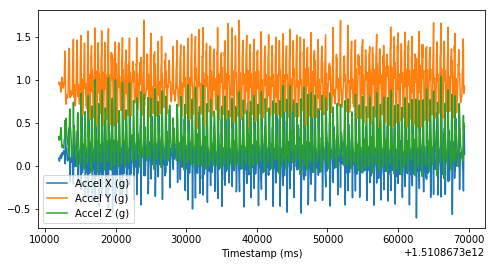

In [71]:
amitest.rawdata[0].plot(figsize=(8,4))

# Use HC03 and test findsignal (Matlab)

# ********

# Look at bicep_left vs sacrum - 11 vs 22 trials
- look at trial difference
- why is sacrum doubled?
- any other patterns?

## Step 3: Aggregate features across several subjects
## Also looking at discrepancy of 5 vs 13 sensors
    - 13 sensor missing half trials

In [ ]:
# unit test and add here
#########################
# cycle through subject list

# create meta/raw data matrix

# extract features

# combine all feature matrix into one final one

########################
# create function when done

In [2]:
# subset of 10 subjects, skipped HC01
# subset = ['HC02', 'HC03', 'HC04', 'HC05', 'HC06', 'HC07','HC08','HC09','HC10','HC11']
# one subject
subset = ['HC02']

In [677]:
for subj in subset:
    print(subj)

HC02


In [15]:
subset = ['HC02']
dictionary_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
annotation_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\controls'
for subj in subset:
    # load pickle
    
    
    
    # step 1
    df = onesubject_meta_raw(dictionary_path, annotation_path, subj)
    HC02_features = feature_extraction(df, sensor_type='accel')

In [16]:
HC02_features

,subject,date,test,task,trial,location,sensor,rawdata,meanX,meanY,...,meanpower_bin11_z,meanpower_bin12_z,meanpower_bin13_z,meanpower_bin14_z,meanpower_bin15_z,meanpower_bin16_z,meanpower_bin17_z,meanpower_bin18_z,meanpower_bin19_z,meanpower_bin20_z
0,HC02,2017-11-13,activity recognition,LYING,0,tibialis_anterior_left,accel,Accel X (g) Accel Y (g) Acce...,-0.049779,-0.901753,...,1.521168e-06,1.571855e-06,1.570076e-06,1.759060e-06,1.658028e-06,1.511982e-06,1.167052e-06,1.633379e-06,1.997187e-06,1.479819e-06
1,HC02,2017-11-13,activity recognition,LYING,0,gastrocnemius_right,accel,Accel X (g) Accel Y (g) Acce...,-0.102802,-0.829551,...,1.853239e-06,2.090799e-06,1.601778e-06,1.505428e-06,1.082194e-06,1.385893e-06,1.225574e-06,1.330999e-06,1.440692e-06,1.559841e-06
2,HC02,2017-11-13,activity recognition,LYING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...,-0.058348,0.183076,...,2.269979e-08,2.174058e-08,2.343769e-08,1.544247e-08,1.614271e-08,1.672363e-08,2.054927e-08,1.836407e-08,1.183496e-08,1.365652e-08
3,HC02,2017-11-13,activity recognition,LYING,0,distal_lateral_shank_right,accel,Accel X (g) Accel Y (g) Acce...,0.105776,0.906628,...,3.367364e-08,2.416130e-08,2.409428e-08,3.310691e-08,3.517773e-08,2.358800e-08,3.311520e-08,2.889551e-08,2.031967e-08,2.555851e-08
4,HC02,2017-11-13,activity recognition,LYING,0,tibialis_anterior_right,accel,Accel X (g) Accel Y (g) Acce...,-0.198152,0.909473,...,1.117714e-06,1.362341e-06,2.060577e-06,2.465715e-06,1.308655e-06,1.561659e-06,1.610429e-06,1.532966e-06,1.301695e-06,1.341989e-06
5,HC02,2017-11-13,activity recognition,LYING,0,posterior_forearm_right,accel,Accel X (g) Accel Y (g) Acce...,0.066610,-0.720693,...,5.818716e-08,5.722675e-08,7.993909e-08,1.099146e-07,1.722232e-07,2.150785e-07,2.915800e-07,4.447235e-07,4.919889e-07,5.704279e-07
6,HC02,2017-11-13,activity recognition,LYING,0,bicep_right,accel,Accel X (g) Accel Y (g) Acce...,-0.389766,-0.169622,...,1.469199e-06,1.640974e-06,1.355730e-06,2.136291e-06,2.489741e-06,1.838155e-06,2.137969e-06,1.935106e-06,3.030136e-06,4.187565e-06
7,HC02,2017-11-13,activity recognition,LYING,0,rectus_femoris_left,accel,Accel X (g) Accel Y (g) Acce...,-0.194103,-0.182047,...,1.828680e-06,1.452148e-06,1.247615e-06,2.470176e-06,1.506914e-06,2.123494e-06,1.861959e-06,1.387050e-06,1.561775e-06,1.637523e-06
8,HC02,2017-11-13,activity recognition,LYING,0,biceps_femoris_right,accel,Accel X (g) Accel Y (g) Acce...,0.109888,0.013114,...,1.451948e-06,1.453238e-06,1.725766e-06,1.397455e-06,1.249781e-06,1.522370e-06,1.580323e-06,1.036328e-06,1.347126e-06,1.226288e-06
9,HC02,2017-11-13,activity recognition,LYING,0,posterior_forearm_left,accel,Accel X (g) Accel Y (g) Acce...,-0.081090,0.903993,...,6.210708e-08,9.869932e-08,8.375677e-08,5.267274e-08,7.915480e-08,4.847091e-08,1.185819e-07,1.436963e-07,1.849029e-07,1.820151e-07


In [705]:
df.groupby('location').count()

,subject,date,test,task,trial,sensor,rawdata
location,,,,,,,
bicep_left,66,66,66,66,66,66,66
bicep_right,66,66,66,66,66,66,66
biceps_femoris_left,66,66,66,66,66,66,66
biceps_femoris_right,66,66,66,66,66,66,66
distal_lateral_shank_left,66,66,66,66,66,66,66
distal_lateral_shank_right,66,66,66,66,66,66,66
gastrocnemius_left,66,66,66,66,66,66,66
gastrocnemius_right,66,66,66,66,66,66,66
medial_chest,66,66,66,66,66,66,66


In [17]:
HC02_features.groupby('location').count()

,subject,date,test,task,trial,sensor,rawdata,meanX,meanY,meanZ,...,meanpower_bin11_z,meanpower_bin12_z,meanpower_bin13_z,meanpower_bin14_z,meanpower_bin15_z,meanpower_bin16_z,meanpower_bin17_z,meanpower_bin18_z,meanpower_bin19_z,meanpower_bin20_z
location,,,,,,,,,,,,,,,,,,,,,
bicep_left,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
bicep_right,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
biceps_femoris_left,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
biceps_femoris_right,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
distal_lateral_shank_left,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
distal_lateral_shank_right,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
gastrocnemius_left,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
gastrocnemius_right,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
medial_chest,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22


In [24]:
HC02_features.loc[HC02_features.location == 'bicep_left']

,subject,date,test,task,trial,location,sensor,rawdata,meanX,meanY,...,meanpower_bin11_z,meanpower_bin12_z,meanpower_bin13_z,meanpower_bin14_z,meanpower_bin15_z,meanpower_bin16_z,meanpower_bin17_z,meanpower_bin18_z,meanpower_bin19_z,meanpower_bin20_z
12,HC02,2017-11-13,activity recognition,LYING,0,bicep_left,accel,Accel X (g) Accel Y (g) Acce...,-0.377622,0.130936,...,0.000001,0.000002,0.000002,0.000002,0.000002,0.000003,0.000003,0.000002,0.000002,0.000003
34,HC02,2017-11-13,activity recognition,SITTING,0,bicep_left,accel,Accel X (g) Accel Y (g) Acce...,-0.948440,0.186656,...,0.000002,0.000001,0.000002,0.000002,0.000002,0.000002,0.000003,0.000002,0.000002,0.000004
50,HC02,2017-11-13,activity recognition,SITTING,1,bicep_left,accel,Accel X (g) Accel Y (g) Acce...,-0.944959,0.121721,...,0.000002,0.000002,0.000002,0.000002,0.000003,0.000003,0.000004,0.000005,0.000004,0.000005
78,HC02,2017-11-13,activity recognition,STANDING,0,bicep_left,accel,Accel X (g) Accel Y (g) Acce...,-0.984961,0.141208,...,0.000002,0.000002,0.000004,0.000001,0.000002,0.000003,0.000003,0.000003,0.000002,0.000002
94,HC02,2017-11-13,activity recognition,STANDING,1,bicep_left,accel,Accel X (g) Accel Y (g) Acce...,-0.986248,0.128456,...,0.000003,0.000006,0.000005,0.000005,0.000010,0.000006,0.000009,0.000012,0.000004,0.000008
110,HC02,2017-11-13,activity recognition,STANDING,2,bicep_left,accel,Accel X (g) Accel Y (g) Acce...,-0.989554,0.107327,...,0.000005,0.000006,0.000003,0.000007,0.000006,0.000005,0.000003,0.000007,0.000005,0.000006
126,HC02,2017-11-13,activity recognition,STANDING,3,bicep_left,accel,Accel X (g) Accel Y (g) Acce...,-0.989327,0.108122,...,0.000002,0.000001,0.000003,0.000003,0.000003,0.000005,0.000004,0.000003,0.000003,0.000005
166,HC02,2017-11-13,activity recognition,WALKING,0,bicep_left,accel,Accel X (g) Accel Y (g) Acce...,-0.985984,0.185118,...,0.000852,0.001104,0.000422,0.001262,0.000516,0.000860,0.000267,0.000696,0.000204,0.000190
182,HC02,2017-11-13,activity recognition,WALKING,1,bicep_left,accel,Accel X (g) Accel Y (g) Acce...,-0.986142,0.194595,...,0.002134,0.002010,0.001366,0.004754,0.000703,0.001235,0.000729,0.000620,0.000608,0.000566
210,HC02,2017-11-13,activity recognition,STAIRS DOWN,0,bicep_left,accel,Accel X (g) Accel Y (g) Acce...,-0.963795,0.174651,...,0.005810,0.000902,0.001060,0.000610,0.000648,0.001498,0.002783,0.001509,0.001525,0.000540


In [25]:
HC02_features.loc[HC02_features.location == 'sacrum']

,subject,date,test,task,trial,location,sensor,rawdata,meanX,meanY,...,meanpower_bin11_z,meanpower_bin12_z,meanpower_bin13_z,meanpower_bin14_z,meanpower_bin15_z,meanpower_bin16_z,meanpower_bin17_z,meanpower_bin18_z,meanpower_bin19_z,meanpower_bin20_z
2,HC02,2017-11-13,activity recognition,LYING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...,-0.058348,0.183076,...,2.269979e-08,2.174058e-08,2.343769e-08,1.544247e-08,1.614271e-08,1.672363e-08,2.054927e-08,1.836407e-08,1.183496e-08,1.365652e-08
16,HC02,2017-11-13,activity recognition,LYING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...,0.054065,0.013683,...,3.468956e-08,3.716701e-08,3.076789e-08,2.804459e-08,2.400356e-08,2.046967e-08,2.135167e-08,3.882576e-08,6.928073e-08,5.222318e-08
24,HC02,2017-11-13,activity recognition,SITTING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...,0.009388,1.008549,...,1.824003e-07,1.808417e-07,2.944516e-07,1.943924e-07,2.276448e-07,1.757966e-07,1.531135e-07,1.481800e-07,1.375997e-07,1.642117e-07
40,HC02,2017-11-13,activity recognition,SITTING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...,-0.003078,1.005490,...,1.390821e-07,1.788269e-07,1.492111e-07,1.361560e-07,1.301188e-07,1.933833e-07,1.364220e-07,2.383983e-07,2.047994e-07,1.959603e-07
54,HC02,2017-11-13,activity recognition,SITTING,2,sacrum,accel,Accel X (g) Accel Y (g) Acce...,0.003018,1.011629,...,1.296341e-07,1.150328e-07,1.429147e-07,1.905910e-07,1.699172e-07,1.209649e-07,1.304577e-07,2.355803e-07,2.315980e-07,2.338800e-07
60,HC02,2017-11-13,activity recognition,SITTING,3,sacrum,accel,Accel X (g) Accel Y (g) Acce...,-0.000764,1.005366,...,5.859118e-07,6.102852e-07,7.698407e-07,8.435538e-07,9.244802e-07,8.603321e-07,1.292058e-06,1.694710e-06,9.942260e-07,7.890030e-07
68,HC02,2017-11-13,activity recognition,STANDING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...,-0.033448,0.976060,...,1.053673e-06,6.275543e-07,5.896008e-07,8.138438e-07,1.016088e-06,8.181896e-07,1.083246e-06,6.670792e-07,3.942311e-07,3.257562e-07
84,HC02,2017-11-13,activity recognition,STANDING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...,-0.017459,0.974043,...,2.708067e-06,4.418478e-06,1.499297e-06,1.650876e-06,2.546796e-06,1.429031e-06,1.526389e-06,1.973133e-06,8.118253e-07,4.614307e-07
100,HC02,2017-11-13,activity recognition,STANDING,2,sacrum,accel,Accel X (g) Accel Y (g) Acce...,-0.023401,0.957882,...,2.899761e-06,1.129600e-06,1.535088e-06,9.660193e-07,6.628776e-07,8.935677e-07,1.610939e-06,8.258640e-07,2.882771e-07,4.298388e-07
116,HC02,2017-11-13,activity recognition,STANDING,3,sacrum,accel,Accel X (g) Accel Y (g) Acce...,-0.034323,0.943444,...,2.859423e-07,8.568084e-07,7.750485e-07,3.975063e-07,5.352130e-07,5.225324e-07,4.311698e-07,6.204568e-07,2.401256e-07,1.555892e-07


# ********

## Why are the non-5 acc sensors cutting in half?

In [11]:
# ***also loaded in the function section above, placed below to quickly modify function prn***
def feature_extraction(df, sensor_type='accel'):
    """
    This function takes a dataframe with metadata and raw data from IMUs,
    filters out accelerometer or gyroscope sensor data from specified locations, 
    then extracts 131 features for each trial.
    
    Input: 
    df - Flattened dataframe with task, trial, location, sensor, and IMU raw data
    sensor_type -   'accel' for accelerometer sensor data only
                    'both' for accelerometer and gyroscope sensor data
                    Default is 'accel'.
    
    Output:
    df_feature - Dataframe with metadata, raw data and features
    """
    # filter accelerometer data
    if sensor_type=='accel':
        df_feature = df.loc[df.sensor == sensor_type]
        #########
        df_feature.reset_index(drop=True, inplace=True)
    # else filter accelerometer and gyro data
    elif sensor_type=='both':
        # acc/gyr locations
        locations = ['sacrum', 'distal_lateral_shank_right', 'distal_lateral_shank_left',
                     'posterior_forearm_right', 'posterior_forearm_left']
        # subset 5 locations
        df_feature = df[df.location.isin(locations)]
        df_feature = df_feature.loc[df_feature.sensor != 'elec']
        
    # drop empty dataframes by using len=0 condition
    df_feature = df_feature[df_feature.rawdata.map(lambda d: len(d)) > 0]
    # reset index
    df_feature.reset_index(drop=True, inplace=True)

    features = pd.DataFrame()
    for ind, val in enumerate(df_feature.rawdata):
        trialfeature = featuretest(val)
        features = features.append(trialfeature, ignore_index=True)
    # concat features to meta/raw data
    df_feature = pd.concat([df_feature,features], axis=1)#, ignore_index=True)
    
    return df_feature

In [738]:
df_feature = df.loc[df.sensor == 'accel']
df_feature.reset_index(drop=True, inplace=True)
# works

In [743]:
df_feature.loc[df_feature.location == 'bicep_left']

,subject,date,test,task,trial,location,sensor,rawdata
12,HC02,2017-11-13,activity recognition,LYING,0,bicep_left,accel,Accel X (g) Accel Y (g) Acce...
28,HC02,2017-11-13,activity recognition,LYING,1,bicep_left,accel,"Empty DataFrame Columns: [Accel X (g), Accel Y..."
44,HC02,2017-11-13,activity recognition,SITTING,0,bicep_left,accel,Accel X (g) Accel Y (g) Acce...
60,HC02,2017-11-13,activity recognition,SITTING,1,bicep_left,accel,Accel X (g) Accel Y (g) Acce...
76,HC02,2017-11-13,activity recognition,SITTING,2,bicep_left,accel,"Empty DataFrame Columns: [Accel X (g), Accel Y..."
92,HC02,2017-11-13,activity recognition,SITTING,3,bicep_left,accel,"Empty DataFrame Columns: [Accel X (g), Accel Y..."
108,HC02,2017-11-13,activity recognition,STANDING,0,bicep_left,accel,Accel X (g) Accel Y (g) Acce...
124,HC02,2017-11-13,activity recognition,STANDING,1,bicep_left,accel,Accel X (g) Accel Y (g) Acce...
140,HC02,2017-11-13,activity recognition,STANDING,2,bicep_left,accel,Accel X (g) Accel Y (g) Acce...
156,HC02,2017-11-13,activity recognition,STANDING,3,bicep_left,accel,Accel X (g) Accel Y (g) Acce...


In [736]:
# test - drops half of the non-5 locations
df_feature = df_feature[df_feature.rawdata.map(lambda d: len(d)) > 0]

In [737]:
df_feature.groupby('location').count()

,subject,date,test,task,trial,sensor,rawdata
location,,,,,,,
bicep_left,11,11,11,11,11,11,11
bicep_right,11,11,11,11,11,11,11
biceps_femoris_left,11,11,11,11,11,11,11
biceps_femoris_right,11,11,11,11,11,11,11
distal_lateral_shank_left,22,22,22,22,22,22,22
distal_lateral_shank_right,22,22,22,22,22,22,22
gastrocnemius_left,11,11,11,11,11,11,11
gastrocnemius_right,11,11,11,11,11,11,11
medial_chest,22,22,22,22,22,22,22


In [734]:
df_feature

,subject,date,test,task,trial,location,sensor,rawdata
0,HC02,2017-11-13,activity recognition,LYING,0,tibialis_anterior_left,accel,Accel X (g) Accel Y (g) Acce...
1,HC02,2017-11-13,activity recognition,LYING,0,gastrocnemius_right,accel,Accel X (g) Accel Y (g) Acce...
2,HC02,2017-11-13,activity recognition,LYING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
3,HC02,2017-11-13,activity recognition,LYING,0,distal_lateral_shank_right,accel,Accel X (g) Accel Y (g) Acce...
4,HC02,2017-11-13,activity recognition,LYING,0,tibialis_anterior_right,accel,Accel X (g) Accel Y (g) Acce...
5,HC02,2017-11-13,activity recognition,LYING,0,posterior_forearm_right,accel,Accel X (g) Accel Y (g) Acce...
6,HC02,2017-11-13,activity recognition,LYING,0,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
7,HC02,2017-11-13,activity recognition,LYING,0,rectus_femoris_left,accel,Accel X (g) Accel Y (g) Acce...
8,HC02,2017-11-13,activity recognition,LYING,0,biceps_femoris_right,accel,Accel X (g) Accel Y (g) Acce...
9,HC02,2017-11-13,activity recognition,LYING,0,posterior_forearm_left,accel,Accel X (g) Accel Y (g) Acce...


In [726]:
df_feature.rawdata[1]

KeyError: 1

In [731]:
df_feature

,subject,date,test,task,trial,location,sensor,rawdata
0,HC02,2017-11-13,activity recognition,LYING,0,tibialis_anterior_left,accel,Accel X (g) Accel Y (g) Acce...
3,HC02,2017-11-13,activity recognition,LYING,0,gastrocnemius_right,accel,Accel X (g) Accel Y (g) Acce...
6,HC02,2017-11-13,activity recognition,LYING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
9,HC02,2017-11-13,activity recognition,LYING,0,distal_lateral_shank_right,accel,Accel X (g) Accel Y (g) Acce...
12,HC02,2017-11-13,activity recognition,LYING,0,tibialis_anterior_right,accel,Accel X (g) Accel Y (g) Acce...
15,HC02,2017-11-13,activity recognition,LYING,0,posterior_forearm_right,accel,Accel X (g) Accel Y (g) Acce...
18,HC02,2017-11-13,activity recognition,LYING,0,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
21,HC02,2017-11-13,activity recognition,LYING,0,rectus_femoris_left,accel,Accel X (g) Accel Y (g) Acce...
24,HC02,2017-11-13,activity recognition,LYING,0,biceps_femoris_right,accel,Accel X (g) Accel Y (g) Acce...
27,HC02,2017-11-13,activity recognition,LYING,0,posterior_forearm_left,accel,Accel X (g) Accel Y (g) Acce...


In [701]:
df_feature = df_feature[df_feature.rawdata.map(lambda d: len(d)) > 0]
# df_feature.reset_index(drop=True, inplace=True)

In [1]:
df_feature.groupby('location').count()

NameError: name 'df_feature' is not defined

In [703]:
df.loc[df.location == 'bicep_right']

,subject,date,test,task,trial,location,sensor,rawdata
18,HC02,2017-11-13,activity recognition,LYING,0,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
19,HC02,2017-11-13,activity recognition,LYING,0,bicep_right,gyro,Empty DataFrame Columns: [] Index: []
20,HC02,2017-11-13,activity recognition,LYING,0,bicep_right,elec,Sample (V) Timestamp (ms) ...
66,HC02,2017-11-13,activity recognition,LYING,1,bicep_right,accel,"Empty DataFrame Columns: [Accel X (g), Accel Y..."
67,HC02,2017-11-13,activity recognition,LYING,1,bicep_right,gyro,Empty DataFrame Columns: [] Index: []
68,HC02,2017-11-13,activity recognition,LYING,1,bicep_right,elec,Empty DataFrame Columns: [Sample (V)] Index: []
114,HC02,2017-11-13,activity recognition,SITTING,0,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
115,HC02,2017-11-13,activity recognition,SITTING,0,bicep_right,gyro,Empty DataFrame Columns: [] Index: []
116,HC02,2017-11-13,activity recognition,SITTING,0,bicep_right,elec,Sample (V) Timestamp (ms) ...
162,HC02,2017-11-13,activity recognition,SITTING,1,bicep_right,accel,Accel X (g) Accel Y (g) Acce...


In [704]:
df_feature.loc[df.location == 'bicep_right']

,subject,date,test,task,trial,location,sensor,rawdata
18,HC02,2017-11-13,activity recognition,LYING,0,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
114,HC02,2017-11-13,activity recognition,SITTING,0,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
162,HC02,2017-11-13,activity recognition,SITTING,1,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
306,HC02,2017-11-13,activity recognition,STANDING,0,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
354,HC02,2017-11-13,activity recognition,STANDING,1,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
402,HC02,2017-11-13,activity recognition,STANDING,2,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
450,HC02,2017-11-13,activity recognition,STANDING,3,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
690,HC02,2017-11-13,activity recognition,WALKING,0,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
738,HC02,2017-11-13,activity recognition,WALKING,1,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
882,HC02,2017-11-13,activity recognition,STAIRS DOWN,0,bicep_right,accel,Accel X (g) Accel Y (g) Acce...


In [686]:
df_feature.loc[df.location == 'sacrum']

,subject,date,test,task,trial,location,sensor,rawdata
6,HC02,2017-11-13,activity recognition,LYING,0,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
7,HC02,2017-11-13,activity recognition,LYING,0,rectus_femoris_left,accel,Accel X (g) Accel Y (g) Acce...
8,HC02,2017-11-13,activity recognition,LYING,0,biceps_femoris_right,accel,Accel X (g) Accel Y (g) Acce...
54,HC02,2017-11-13,activity recognition,SITTING,2,sacrum,accel,Accel X (g) Accel Y (g) Acce...
55,HC02,2017-11-13,activity recognition,SITTING,2,distal_lateral_shank_right,accel,Accel X (g) Accel Y (g) Acce...
56,HC02,2017-11-13,activity recognition,SITTING,2,posterior_forearm_right,accel,Accel X (g) Accel Y (g) Acce...
102,HC02,2017-11-13,activity recognition,STANDING,2,tibialis_anterior_right,accel,Accel X (g) Accel Y (g) Acce...
103,HC02,2017-11-13,activity recognition,STANDING,2,posterior_forearm_right,accel,Accel X (g) Accel Y (g) Acce...
104,HC02,2017-11-13,activity recognition,STANDING,2,bicep_right,accel,Accel X (g) Accel Y (g) Acce...
150,HC02,2017-11-13,activity recognition,STANDING,7,posterior_forearm_right,accel,Accel X (g) Accel Y (g) Acce...


In [ ]:
# run bigger dataset through ML pipeline


##

# Next Action

Next action
1. run through ML pipeline - IN PROGRESS
2. sliding window clipping - talk to Megan, Ami
3. step 3: aggregate several subjects - CURRENT

Skip
- one hot encoding target variables - SKIP

Done
- unstack act_dict
    - trials all separated
- get timestamp info - check annotations
- Modify to take unstack dict
    - five sensor features
    - all sensor features
- completed featuretest() instead of feature_extraction131() to handle unstacked dict
- Calls subfunctions
    - power_spectra_welch_axis
    - HPfilter_testclip to handle unstacked structure (vs HPfilter - takes act_dict structure)
- figure 5 sensor loc feature extraction fcn
    - label features with -acc or -gyr

# Misc code

In [665]:
#all subj data files in repository
d = os.listdir(path)
f = [filename[0:4] for filename in d if filename.startswith('HC')]
#skip existing data dictionary files in ../biostamp_data/Data_dict
fd = os.listdir(dict_path)
fd = [x[:4] for x in fd if x.startswith('HC')]

# subjects that need to extract into data dictionary
print(list(set(f) - set(fd)))

['HC40', 'HC42', 'HC37', 'HC41', 'HC38', 'HC39', 'HC36']
